In [1]:
%matplotlib inline
# Load necessary modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41813,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:36237,Total threads: 4
Dashboard: http://127.0.0.1:37517/status,Memory: 143.87 GiB
Nanny: tcp://127.0.0.1:39407,


In [3]:
chunk = {'yu_ocean':52, 'xu_ocean':1200}
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

0.3.0


In [4]:
# Average U_along into mean, seasonal, monthly and annual fields

u_along_da_mean = u_along.mean('time').u_along_contour_binned
u_along_da_seasonal = u_along.groupby('time.month').mean('time').u_along_contour_binned
u_along_da_annual = u_along.groupby('time.year').mean('time').u_along_contour_binned
## CHECK: Is this the right way? 
u_along_da_monthly = u_along.resample(time='1M').mean().u_along_contour_binned

u_along_da_mean.load()
u_along_da_seasonal.load()
u_along_da_annual.load()
u_along_da_monthly.load()

<xarray.DataArray 'u_along_contour_binned' (time: 732, st_ocean: 75,
                                            lon_bin_midpoints: 1428)>
array([[[-0.02359511, -0.02475564, -0.02657239, ..., -0.0204653 ,
         -0.02053152, -0.02350026],
        [-0.01865366, -0.01979311, -0.02162974, ..., -0.01303114,
         -0.01375674, -0.01694079],
        [-0.01603528, -0.01716227, -0.01901062, ..., -0.00900011,
         -0.0100713 , -0.01337444],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.06889385, -0.06873107, -0.06851074, ..., -0.02077237,
         -0.02169113, -0.02693162],
        [-0.06278588, -0.06240495, -0.06204439, ..., -0.01473967,
         -0.01655271, -0.02205193],
        [-0.05906674, -0.05856833, -0.05814252, ..., -0.01109173,
         -0.01338399, -0.0190114 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0376156 , -0.03683981, -0.03611625, ..., -0.03758969,
         -0.03398371, -0.03630787],
        [-0.03121829, -0.0303874 , -0.02965705, ..., -0.0294911 ,
         -0.02702347, -0.02966545],
        [-0.02686711, -0.02600385, -0.02527127, ..., -0.02429345,
         -0.0225731 , -0.02540491],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * st_ocean           (st_ocean) float64 0.5413 1.681 ... 5.511e+03 5.709e+03
  * lon_bin_midpoints  (lon_bin_midpoints) float64 -278.5 -278.2 ... 78.0 78.25
  * time               (time) datetime64[ns] 1958-01-31 ... 2018-12-31

In [5]:
## GMM doesn't accept any NaNs - so, we need to drop all NaNs in depth space and normalise onto a sigma co-ordinate (between 0 and 1)
depths_2d_da = u_along_da_mean.st_ocean
depths_2d_da = depths_2d_da.expand_dims(dim={'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints.size},axis=1)\
.assign_coords({'lon_bin_midpoints':u_along_da_mean.lon_bin_midpoints})
depths_2d_da = (depths_2d_da*u_along_da_mean/u_along_da_mean).rename('depth')

# Calculate the values of M and O, the columns and rows of U_along
n_rows = u_along_da_mean.shape[0]
o_cols = u_along_da_mean.shape[1]
m_rows = n_rows // o_cols

reshaped_u_along_df_season = []
reshaped_u_along_df_annual = []
reshaped_u_along_df_monthly = []

# Reshape the DataFrame to an MxO shape, and drop NaNs from the depth axis
reshaped_u_along_df = pd.DataFrame(np.array(u_along_da_mean).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_u_along_df = reshaped_u_along_df.dropna(how='all', axis=0)
for i in tqdm(range(12)):
    tmp = (pd.DataFrame(np.array(u_along_da_seasonal)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_seasonal.st_ocean, columns=u_along_da_seasonal.lon_bin_midpoints))
    reshaped_u_along_df_season.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_annual.year.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_annual)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_annual.st_ocean, columns=u_along_da_annual.lon_bin_midpoints))
    reshaped_u_along_df_annual.append(tmp.dropna(how='all', axis=0))
for i in tqdm(range(u_along_da_monthly.time.size)):
    tmp = (pd.DataFrame(np.array(u_along_da_monthly)[i,:,:].reshape(n_rows, o_cols), index=u_along_da_monthly.st_ocean, columns=u_along_da_monthly.lon_bin_midpoints))
    reshaped_u_along_df_monthly.append(tmp.dropna(how='all', axis=0))

## Do the same for the depth array
reshaped_depths_df = pd.DataFrame(np.array(depths_2d_da).reshape(n_rows, o_cols), index=u_along_da_mean.st_ocean, columns=u_along_da_mean.lon_bin_midpoints)
reshaped_depths_df = reshaped_depths_df.dropna(how='all', axis=0)

  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 732/732 [03:07<00:00,  3.91it/s]


In [6]:
## Create sigma bins for interpolation
normalised_depths_df = reshaped_depths_df/reshaped_depths_df.max(skipna=True, axis=0)
depth_bins = reshaped_depths_df.index/reshaped_depths_df.index[-1]

In [7]:
%%time
## Interpolate onto a uniform [0,1] sigma co-ordinate for all profiles
import scipy.interpolate as interpolate

new_u_along = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_season_list = []
new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_annual_list = []
new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size))
new_u_along_monthly_list = []

for i in tqdm(range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df[normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along[:,i] = f_values_u_along(depth_bins)

for j in tqdm(range(12)):
    new_u_along_season = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_season[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_season[:,i] = f_values_u_along(depth_bins)
    new_u_along_season_list.append(new_u_along_season)

for j in tqdm(range(u_along_da_annual.year.size)):
    new_u_along_annual = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_annual[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_annual[:,i] = f_values_u_along(depth_bins)
    new_u_along_annual_list.append(new_u_along_annual)

for j in tqdm(range(u_along_da_monthly.time.size)):
    new_u_along_monthly = np.zeros((depth_bins.size, normalised_depths_df.keys().size)) 
    for i in (range(normalised_depths_df.keys().size)):
        f_values_u_along = interpolate.interp1d(normalised_depths_df[normalised_depths_df.keys()[i]].values, reshaped_u_along_df_monthly[j][normalised_depths_df.keys()[i]].values, fill_value='extrapolate')
        new_u_along_monthly[:,i] = f_values_u_along(depth_bins)
    new_u_along_monthly_list.append(new_u_along_monthly)

  0%|          | 0/1428 [00:00<?, ?it/s]

100%|██████████| 732/732 [03:21<00:00,  3.64it/s]

CPU times: user 3min 47s, sys: 33.3 s, total: 4min 21s
Wall time: 3min 43s


In [8]:
## Define the dataframe that will be fed into the GMM -  we are dropping NaNs
new_u_along_df = pd.DataFrame(new_u_along, index=depth_bins, columns=normalised_depths_df.keys())
new_u_along_df = new_u_along_df.dropna(how='all', axis=1)

new_u_along_df_season = []
new_u_along_df_annual = []
new_u_along_df_monthly = []

for j in tqdm(range(12)):
    tmp = pd.DataFrame(new_u_along_season_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_season.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_annual.year.size)):
    tmp = pd.DataFrame(new_u_along_annual_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_annual.append(tmp.dropna(how='all', axis=1))

for j in tqdm(range(u_along_da_monthly.time.size)):
    tmp = pd.DataFrame(new_u_along_monthly_list[j], index=depth_bins, columns=normalised_depths_df.keys())
    new_u_along_df_monthly.append(tmp.dropna(how='all', axis=1))

100%|██████████| 732/732 [00:00<00:00, 961.17it/s]


In [9]:
# Convert into DataArrays
u_along_da = xr.DataArray(new_u_along_df.values, \
                              coords={'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_seasons = xr.DataArray(np.array(new_u_along_df_season), coords={'month':u_along_da_seasonal.month.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'month':u_along_da_seasonal.month.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_yearly = xr.DataArray(np.array(new_u_along_df_annual), coords={'year':u_along_da_annual.year.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'year':u_along_da_annual.year.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')
u_along_da_months = xr.DataArray(np.array(new_u_along_df_monthly), coords={'time':u_along_da_monthly.time.values, 'depth':depth_bins, 'lon':u_along_da_mean.lon_bin_midpoints.values}, \
                              dims={'time':u_along_da_monthly.time.size,'depth':depth_bins.size, 'lon':u_along_da_mean.lon_bin_midpoints.size}, name='u_along')

In [10]:
# Define the surface, depth u_along that will be fed into the GMM
surf_u_along_da = u_along_da.sel(depth=slice(0,0.3))
deep_u_along_da = u_along_da.sel(depth=slice(0.3, None))

surf_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0,0.3))
deep_u_along_da_seasons = u_along_da_seasons.sel(depth=slice(0.3, None))

surf_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0,0.3))
deep_u_along_da_annual = u_along_da_yearly.sel(depth=slice(0.3, None))

surf_u_along_da_months = u_along_da_months.sel(depth=slice(0,0.3))
deep_u_along_da_months = u_along_da_months.sel(depth=slice(0.3, None))

## CHECK: Note the depth-averaging below is NOT weighted - as it turns out this doesn't 
## make a difference to the regime definitions

surf_u_along_da_avg = surf_u_along_da.mean('depth')
deep_u_along_da_avg = deep_u_along_da.mean('depth')

surf_u_along_da_seasons_avg = surf_u_along_da_seasons.mean('depth')
deep_u_along_da_seasons_avg = deep_u_along_da_seasons.mean('depth')

surf_u_along_da_annual_avg = surf_u_along_da_annual.mean('depth')
deep_u_along_da_annual_avg = deep_u_along_da_annual.mean('depth')

surf_u_along_da_months_avg = surf_u_along_da_months.mean('depth')
deep_u_along_da_months_avg = deep_u_along_da_months.mean('depth')

## 'result' is the array that is fed into GMM

result_mean = xr.concat([(surf_u_along_da_avg/surf_u_along_da_avg.std()-deep_u_along_da_avg/deep_u_along_da_avg.std()),\
                     ((u_along_da/abs(u_along_da)).isel(depth=0))\
                         /((u_along_da/abs(u_along_da)).isel(depth=0)).std()], dim='loc')
result_seasons = xr.concat([(surf_u_along_da_seasons_avg/surf_u_along_da_seasons_avg.std()-deep_u_along_da_seasons_avg/deep_u_along_da_seasons_avg.std()),\
                     ((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0))\
                            /((u_along_da_seasons/abs(u_along_da_seasons)).isel(depth=0)).std()], dim='loc')
result_annual = xr.concat([(surf_u_along_da_annual_avg/surf_u_along_da_annual_avg.std()-deep_u_along_da_annual_avg/deep_u_along_da_annual_avg.std()),\
                     ((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0))\
                            /((u_along_da_yearly/abs(u_along_da_yearly)).isel(depth=0)).std()], dim='loc')
result_months = xr.concat([(surf_u_along_da_months_avg/surf_u_along_da_months_avg.std()-deep_u_along_da_months_avg/deep_u_along_da_months_avg.std()),\
                     ((u_along_da_months/abs(u_along_da_months)).isel(depth=0))\
                            /((u_along_da_months/abs(u_along_da_months)).isel(depth=0)).std()], dim='loc')



In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

n_clusters = []
labels_gmm = []
centers_gmm = []
probs_gmm = []

aic_gmm = []
bic_gmm = []
silhouette_gmm = []

X = result_mean.T

k_clusters = range(1,22)
# We are varying number of clusters to see which is optimal using some diagnostics like AIC, BIC etc. 
for k in tqdm(k_clusters):
    n_clusters.append(k)
    # This is the GMM model definition
    gmm = GaussianMixture(n_components=k, random_state=42)
    # Labels is the actual mask that is produced
    labels_gmm.append(gmm.fit_predict(X))
    centers_gmm.append(gmm.means_)
    probs_gmm.append(gmm.predict_proba(X))
    aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))
    if k>=3:
        silhouette_gmm.append(silhouette_score(X, labels_gmm[k-2], metric='euclidean'))


100%|██████████| 21/21 [00:01<00:00, 15.92it/s]


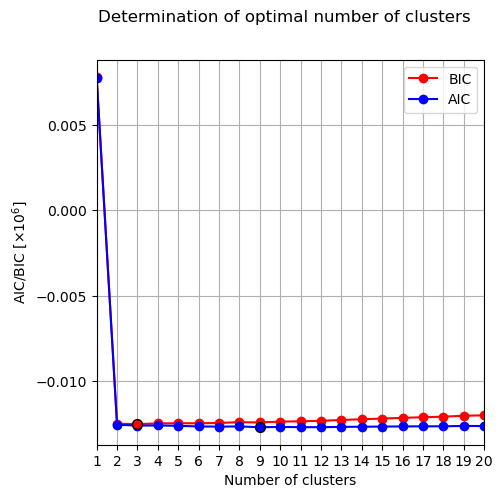

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# axs = axs.ravel()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)

axs.plot(n_clusters, np.array(bic_gmm)/10**6, 'r-o', label='BIC')
axs.plot(n_clusters, np.array(aic_gmm)/10**6, 'b-o', label='AIC')
axs.scatter(n_clusters[np.argmin(aic_gmm)], aic_gmm[np.argmin(aic_gmm)]/10**6, 50, color='blue', ec='k', zorder=10000)
axs.scatter(n_clusters[np.argmin(bic_gmm)], bic_gmm[np.argmin(bic_gmm)]/10**6, 50, color='red', ec='k', zorder=10000)

axs.set_xticks(n_clusters)
axs.set_xlabel('Number of clusters')
axs.set_xlim(1,20)
axs.grid()
axs.set_ylabel(r'AIC/BIC [$\times10^6$]')
axs.legend()

plt.suptitle('Determination of optimal number of clusters', fontsize=12)
plt.show()

In [13]:
# Note: Optimal n is 1 less than the actual number of clusters, so n_optimal = 2 implies 3 clusters, etc. 
n_optimal = 2

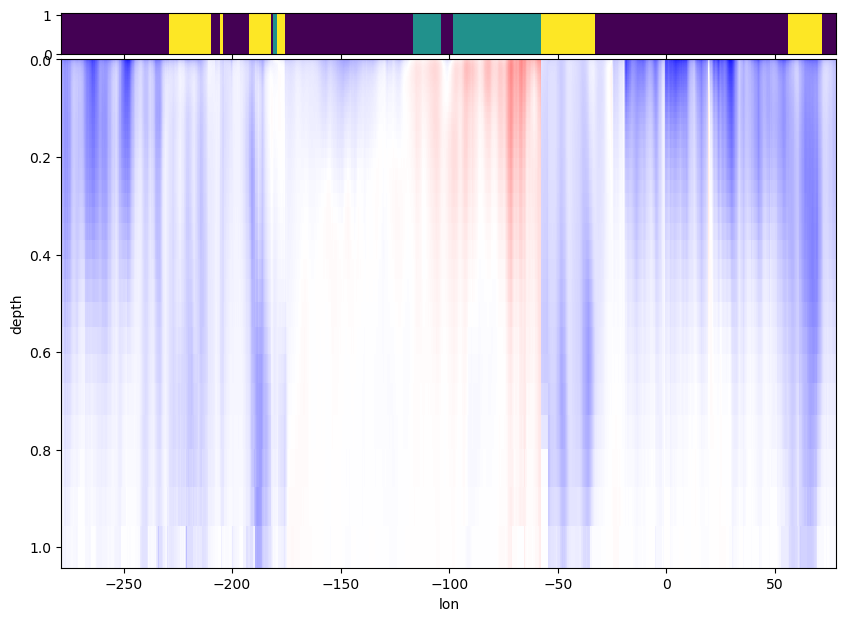

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.02, wspace=0.02)

axs[0].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm[n_optimal][:,np.newaxis], depth_bins.size, axis=-1).T)
u_along_da.plot(ax=axs[1], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
axs[1].invert_yaxis()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
labels_gmm_seasons = []
for i in tqdm(range(12)):
    Y = result_seasons.isel(month=i).T
    gmm = GaussianMixture(n_components=3, random_state=37)
    labels_gmm_seasons.append(gmm.fit(X).predict(Y))

100%|██████████| 12/12 [00:00<00:00, 112.40it/s]


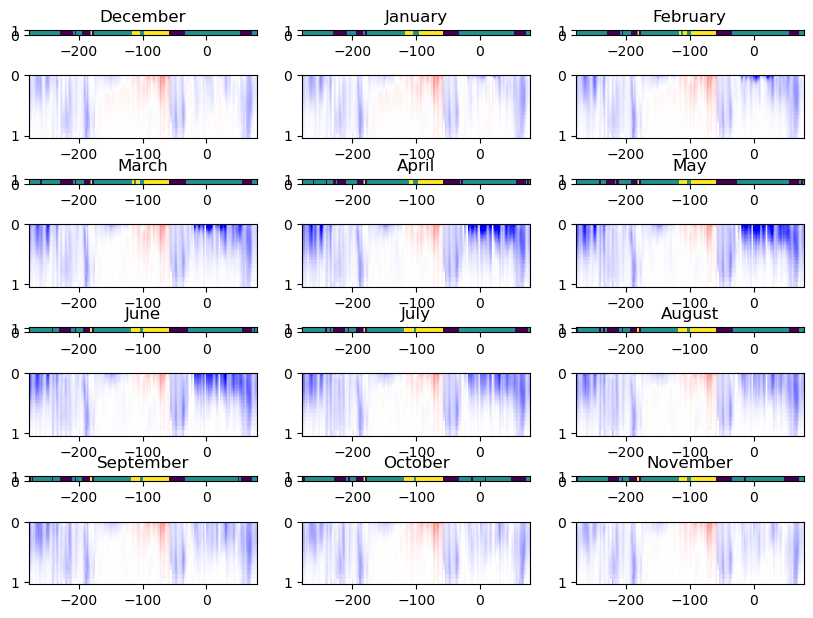

In [16]:
fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(10,12*0.6), gridspec_kw={'height_ratios': [0.08,1,0.08,1,0.08,1,0.08,1]})
axs = axs.ravel()
plt.subplots_adjust(hspace = 1.2, wspace=0.2)

label_inds = [0,1,2,6,7,8,12,13,14,18,19,20]
vel_inds = [3,4,5,9,10,11,15,16,17,21,22,23]
seasons_inds = [11,0,1,2,3,4,5,6,7,8,9,10]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for j in range(12):
    axs[label_inds[j]].pcolor(u_along_da_mean.lon_bin_midpoints.values , depth_bins, np.repeat(labels_gmm_seasons[seasons_inds[j]][:,np.newaxis], depth_bins.size, axis=-1).T)
    u_along_da_seasons.isel(month=seasons_inds[j]).plot(ax=axs[vel_inds[j]], add_colorbar=False, vmin=-0.3, vmax=0.3, cmap=plt.cm.bwr)
    axs[vel_inds[j]].invert_yaxis()
    axs[label_inds[j]].set_title(months[seasons_inds[j]])
    axs[vel_inds[j]].set_title('')
    axs[vel_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_ylabel('')
    axs[label_inds[j]].set_xlabel('')
    axs[vel_inds[j]].set_xlabel('')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_seasons.png', dpi=300, bbox_inches='tight')
plt.show()

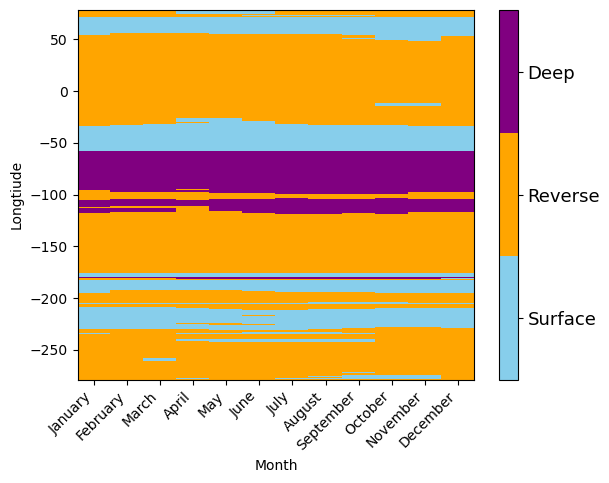

In [17]:
colors = ['skyblue', 'orange', 'purple']
values = [0, 1, 2]
classes = ['Surface', 'Reverse', 'Deep']
cmap = plt.cm.colors.ListedColormap(colors)

plt.pcolor(months,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_seasons).T, cmap=cmap)
plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Month')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_season_labels.png', dpi=300, bbox_inches='tight')
plt.show()

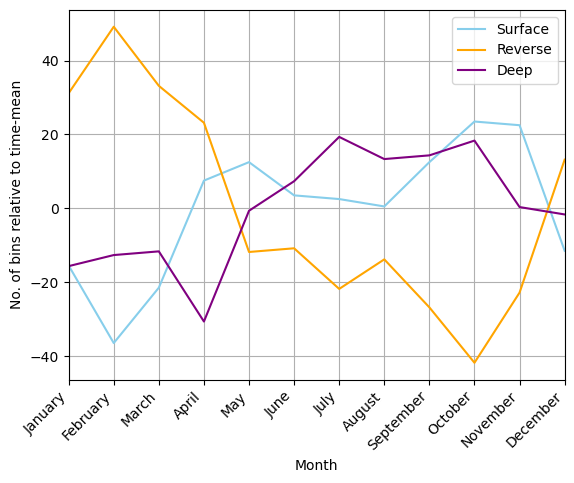

In [18]:
cnt_szn = np.zeros((3,12))
for j in range(3):
    for i in range(12):
        cnt_szn[j,i] = labels_gmm_seasons[i].tolist().count(j)

    plt.plot(cnt_szn[j,:]-np.nanmean(cnt_szn[j,:]), c = colors[j], label = classes[j])
plt.gca().set_xticks(np.arange(0,12))
plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Month')
plt.xlim(0,11)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
labels_gmm_annual = []
for i in tqdm(range(u_along_da_yearly.year.size)):
    Y = result_annual.isel(year=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_annual.append(gmm.fit(X).predict(Y))

100%|██████████| 61/61 [00:00<00:00, 105.08it/s]


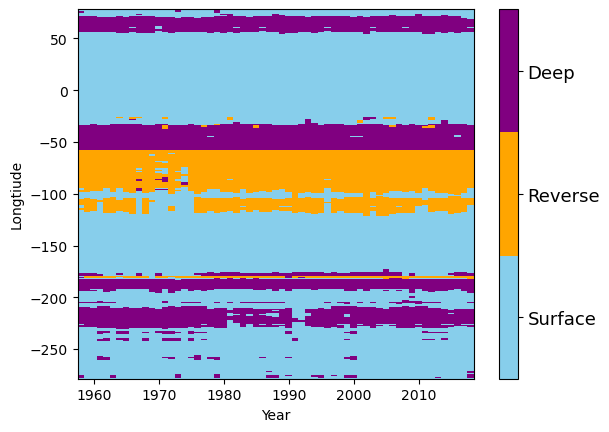

In [20]:
plt.pcolor(u_along_da_annual.year,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_annual).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_annual_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 61/61 [00:00<00:00, 39097.27it/s]


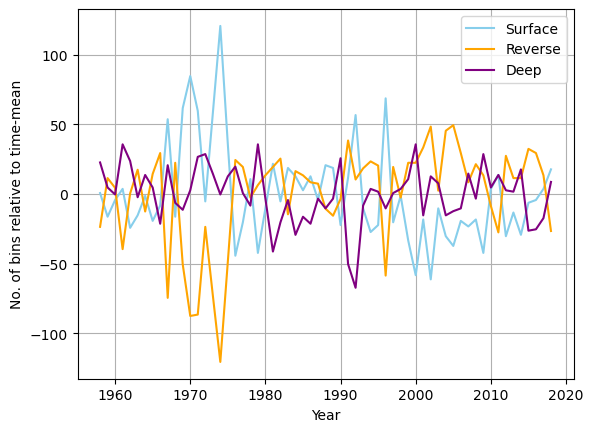

In [21]:
cnt_anno = np.zeros((3,u_along_da_yearly.year.size))
for j in range(3):
    for i in tqdm(range(u_along_da_yearly.year.size)):
        cnt_anno[j,i] = labels_gmm_annual[i].tolist().count(j)

    plt.plot(u_along_da_yearly.year, cnt_anno[j,:]-np.nanmean(cnt_anno[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Year')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_annual.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
labels_gmm_months = []
for i in tqdm(range(u_along_da_monthly.time.size)):
    Y = result_months.isel(time=i).T
    gmm = GaussianMixture(n_components=3, random_state=42)
    labels_gmm_months.append(gmm.fit(X).predict(Y))

100%|██████████| 732/732 [00:06<00:00, 104.83it/s]


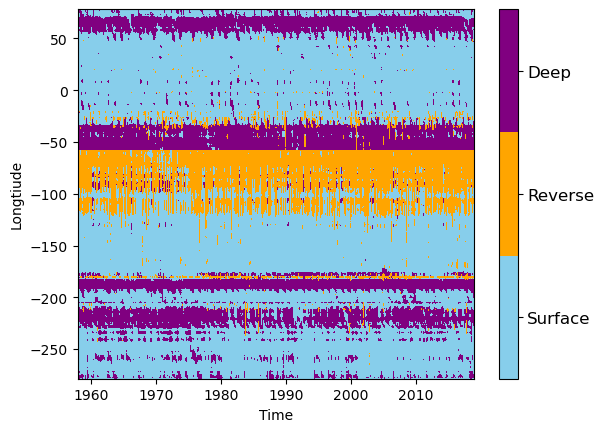

In [23]:
plt.pcolor(np.arange(u_along_da_months.time.size)/12+1958,  u_along_da_mean.lon_bin_midpoints.values, np.array(labels_gmm_months).T, cmap=cmap)
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
cbar = plt.colorbar()
# cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_yticks([1/3,1,5/3])
cbar.ax.set_yticklabels(classes)
plt.ylabel('Longtiude')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/GMM_ASC_trained_monthly_labels.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 732/732 [00:00<00:00, 40974.10it/s]

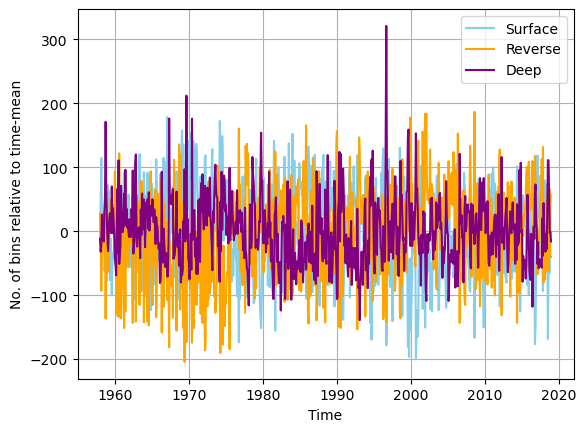

In [24]:
cnt_monthly = np.zeros((3,u_along_da_monthly.time.size))
for j in range(3):
    for i in tqdm(range(u_along_da_monthly.time.size)):
        cnt_monthly[j,i] = labels_gmm_months[i].tolist().count(j)

    plt.plot(np.arange(u_along_da_months.time.size)/12+1958, cnt_monthly[j,:]-np.nanmean(cnt_monthly[j,:]), c = colors[j], label = classes[j])
# plt.gca().set_xticks(np.arange(0,12))
# plt.gca().set_xticklabels(months, rotation=45, ha='right')
plt.legend()
plt.grid()
plt.ylabel('No. of bins relative to time-mean')
plt.xlabel('Time')
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/labels_dist_monthly.png', dpi=300, bbox_inches='tight')
plt.show()

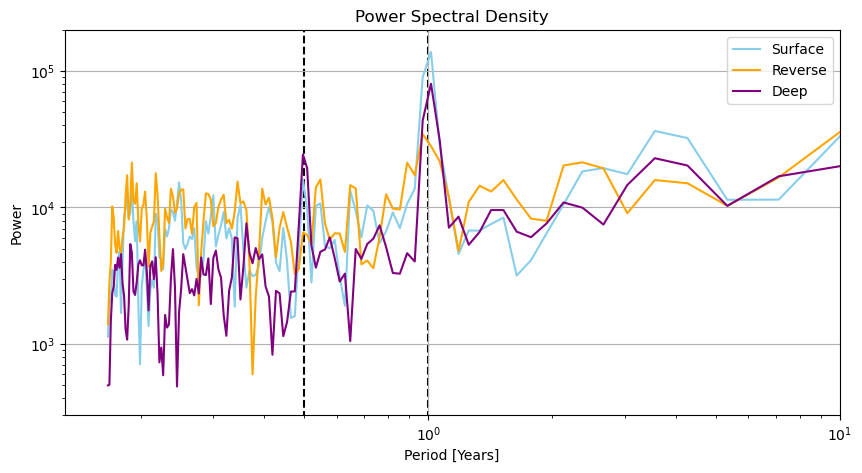

In [25]:
from scipy import signal
# Plot the power spectral density
plt.figure(figsize=(10, 5))

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(cnt_monthly[j,:], fs=1)
    plt.loglog(1/frequencies/12, psd, c = colors[j], label = classes[j])

plt.title('Power Spectral Density')
plt.vlines(0.5,1e2,1e6, color='black', linestyle='dashed', zorder=-1)
plt.vlines(1,1e2,1e6, color='black', linestyle='dashed', zorder=-1)

plt.ylim(3e2,2e5)
plt.xlabel('Period [Years]')
plt.ylabel('Power')
plt.xlim(0,10)
plt.grid()
plt.legend()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/monthly_power_spectra.png', dpi=300, bbox_inches='tight')
plt.show()

## Assess u_along and CSHT in regimes

In [26]:
## Convert the mask with label numbers to an array
labels_masks = np.ones((3, np.array(labels_gmm_months).shape[0], np.array(labels_gmm_months).shape[1]))*np.nan

for i in range(3):
    labels_masks[i,:,:] = np.ma.where(np.array(labels_gmm_months)==i, 1, np.nan)

clustering_mask = xr.DataArray(labels_masks, dims = {'regime':np.arange(3).size, 'time':u_along_da_months.time.size, \
                                                     'lon':u_along_da_months.lon.size}, coords = {'regime':classes, 'time':u_along_da_months.time, \
                                                     'lon':u_along_da_months.lon})

In [27]:
masked_u_along = u_along_da_monthly.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*clustering_mask
masked_u_along.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regime: 3)>
array([[[[        nan,         nan, -0.02359511],
         [        nan,         nan, -0.02475564],
         [        nan,         nan, -0.02657239],
         ...,
         [-0.0204653 ,         nan,         nan],
         [-0.02053152,         nan,         nan],
         [-0.02350026,         nan,         nan]],

        [[        nan,         nan, -0.01865366],
         [        nan,         nan, -0.01979311],
         [        nan,         nan, -0.02162974],
         ...,
         [-0.01303114,         nan,         nan],
         [-0.01375674,         nan,         nan],
         [-0.01694079,         nan,         nan]],

        [[        nan,         nan, -0.01603528],
         [        nan,         nan, -0.01716227],
         [        nan,         nan, -0.01901062],
         ...,
...
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]],

        [[        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         ...,
         [        nan,         nan,         nan],
         [        nan,         nan,         nan],
         [        nan,         nan,         nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

In [28]:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()
CSHT_months = ((CSHT_along_monthly.binned_cross_slope_heat_trans+CSHT_along_monthly.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})

In [29]:
masked_CSHT = CSHT_months*clustering_mask
masked_CSHT.load()

<xarray.DataArray (time: 732, depth: 75, lon: 1428, regime: 3)>
array([[[[            nan,             nan, -5.01025119e+09],
         [            nan,             nan, -3.71894267e+09],
         [            nan,             nan, -5.73132132e+09],
         ...,
         [-1.90749223e+10,             nan,             nan],
         [-2.01919225e+10,             nan,             nan],
         [-2.06019626e+10,             nan,             nan]],

        [[            nan,             nan, -8.25905744e+09],
         [            nan,             nan, -7.24946920e+09],
         [            nan,             nan, -9.17167711e+09],
         ...,
         [-2.16314000e+10,             nan,             nan],
         [-2.25934516e+10,             nan,             nan],
         [-2.29391463e+10,             nan,             nan]],

        [[            nan,             nan, -1.07717302e+10],
         [            nan,             nan, -1.00464920e+10],
         [            nan,             nan, -1.18972073e+10],
         ...,
...
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-31 1958-02-28 ... 2018-12-31
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

Doing the same for daily data.

In [30]:
#Importing average clustering mask
mean_mask=xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
mean_mask=mean_mask.regimes_mask.load()

In [31]:
#daily u masked
masked_u_alongday = u_along.rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mean_mask
masked_u_alongday.load()

masked_CSHT_day = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*0.08).rename({'st_ocean':'depth', 'lon_bin_midpoints':'lon'})*mean_mask
masked_CSHT_day.load()

<xarray.DataArray (time: 22265, depth: 75, lon: 1428, regime: 3)>
array([[[[ 4.79843516e+09,             nan,             nan],
         [ 5.79353510e+09,             nan,             nan],
         [ 5.34979281e+09,             nan,             nan],
         ...,
         [-6.85538312e+09,             nan,             nan],
         [-8.15707587e+09,             nan,             nan],
         [-8.14844248e+09,             nan,             nan]],

        [[ 2.33516368e+09,             nan,             nan],
         [ 3.09579612e+09,             nan,             nan],
         [ 2.58961048e+09,             nan,             nan],
         ...,
         [-4.37748142e+09,             nan,             nan],
         [-5.54757104e+09,             nan,             nan],
         [-5.68992154e+09,             nan,             nan]],

        [[ 3.75746724e+08,             nan,             nan],
         [ 9.87782840e+08,             nan,             nan],
         [ 5.75067259e+08,             nan,             nan],
         ...,
...
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]])
Coordinates:
  * depth    (depth) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * lon      (lon) float64 -278.5 -278.2 -278.0 -277.8 ... 77.5 77.75 78.0 78.25
  * time     (time) datetime64[ns] 1958-01-01T12:00:00 ... 2018-12-31T12:00:00
  * regime   (regime) <U7 'Surface' 'Reverse' 'Deep'

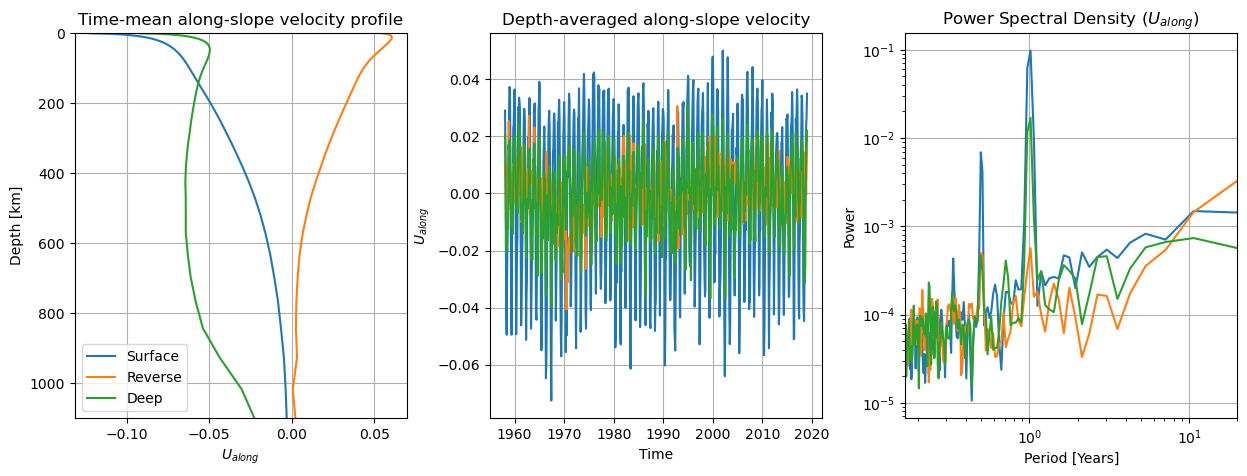

In [32]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_along.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_along.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_along.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_along.isel(regime=0).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
(masked_u_along.isel(regime=1).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
(masked_u_along.isel(regime=2).mean('lon').mean('depth')-\
 masked_u_along.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_along.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters.png', dpi=300, bbox_inches='tight')
plt.show()



In [33]:
masked_u_alongday = masked_u_alongday.u_along_contour_binned

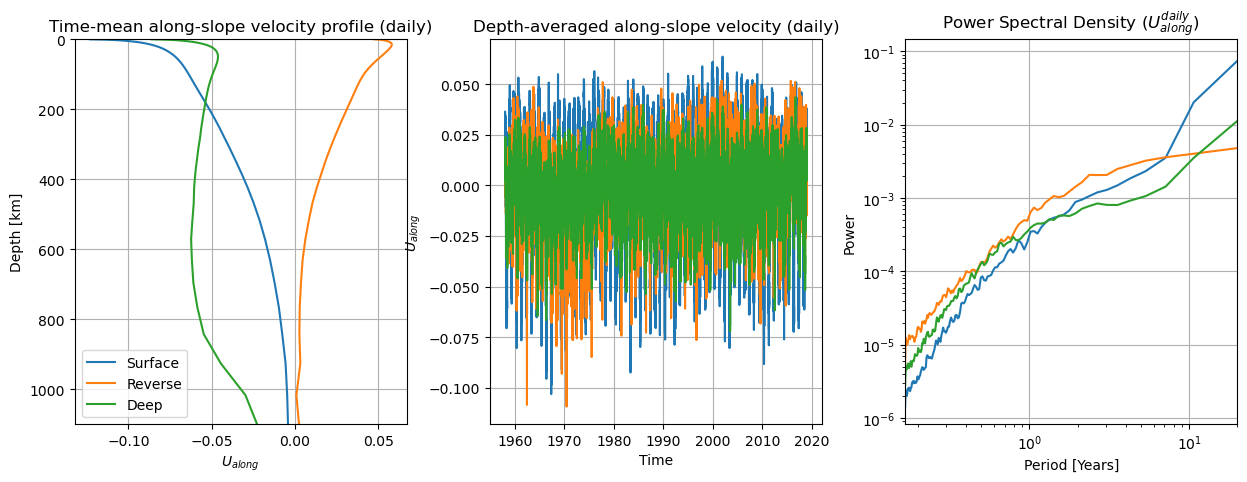

In [34]:
#for the daily data
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_alongday.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_alongday.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_alongday.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_alongday.isel(regime=0).mean('lon').mean('depth')-\
 masked_u_alongday.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
(masked_u_alongday.isel(regime=1).mean('lon').mean('depth')-\
 masked_u_alongday.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
(masked_u_alongday.isel(regime=2).mean('lon').mean('depth')-\
 masked_u_alongday.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_alongday.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile (daily)')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity (daily)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}^{daily}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

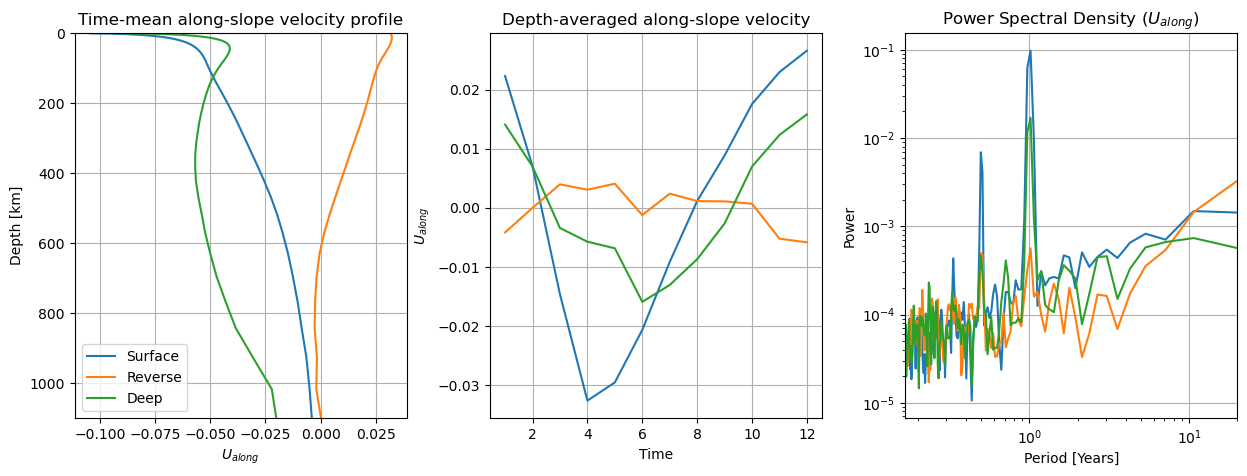

In [35]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_along.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


for daily

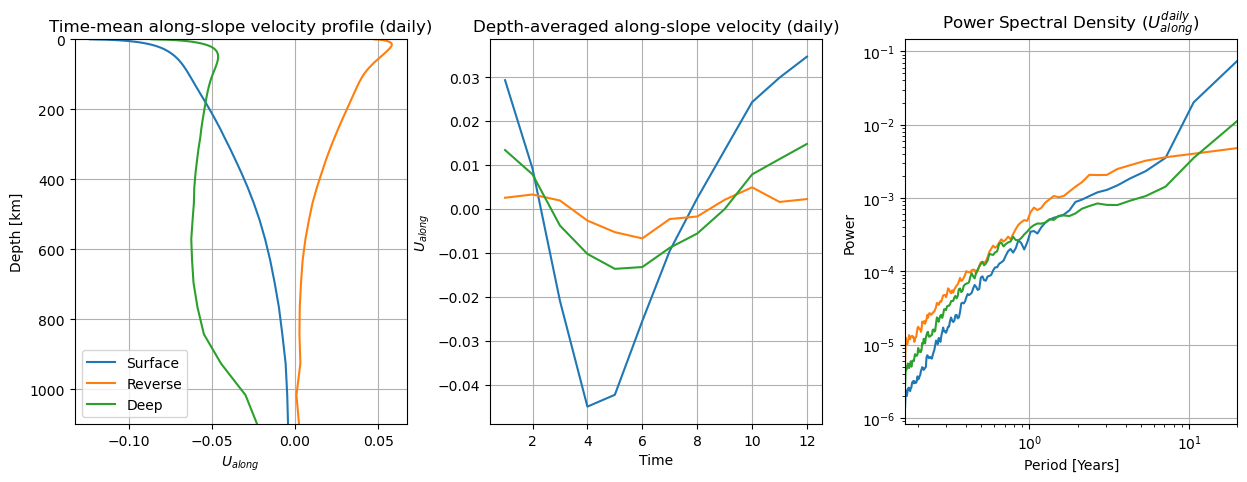

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_u_alongday.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_u_alongday.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_u_alongday.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_u_alongday.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_u_alongday.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_u_alongday.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_u_alongday.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_u_alongday.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_u_alongday.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_u_alongday.isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean along-slope velocity profile (daily)')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$U_{along}$')

axs[1].grid()
axs[1].set_title('Depth-averaged along-slope velocity (daily)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$U_{along}$')

axs[2].set_title('Power Spectral Density ($U_{along}^{daily}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/U_along_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()

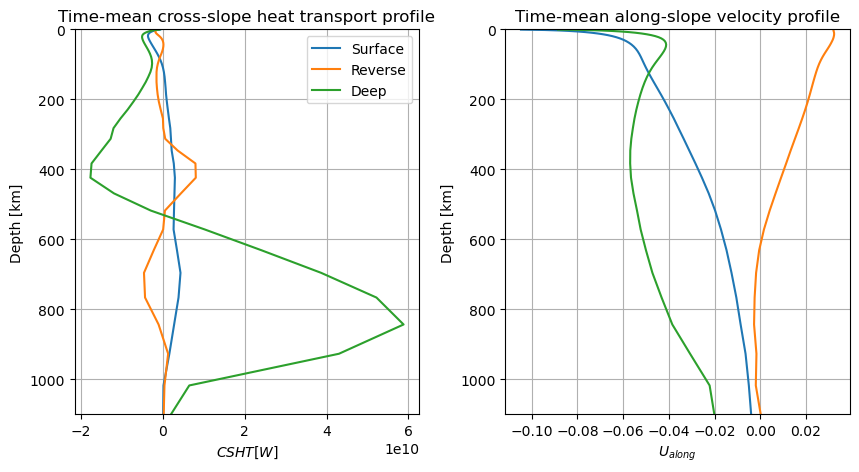

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

masked_u_along.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[0])
masked_u_along.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[1])
masked_u_along.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[2])

# (masked_CSHT.isel(regime=0).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=0).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[0])
# (masked_CSHT.isel(regime=1).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=1).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[1])
# (masked_CSHT.isel(regime=2).mean('lon').mean('depth')-\
#  masked_CSHT.isel(regime=2).mean('lon').mean('depth').mean('time')).plot(ax=axs[1], label = classes[2])

# for j in range(3):
#     # Compute the power spectral density
#     frequencies, psd = signal.welch(masked_CSHT.isel(regime=j).mean('lon').mean('depth').values, fs=1)
#     axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_title('Time-mean along-slope velocity profile')
axs[1].set_ylim(1100,0)
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('$U_{along}$')

# axs[1].grid()
# axs[1].set_title('Depth-averaged cross-slope heat transport')
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('$CSHT [W]$')

# axs[2].set_title('Power Spectral Density ($CSHT$)')
# axs[2].set_xlabel('Period [Years]')
# axs[2].set_ylabel('Power')
# axs[2].set_xlim(2/12,20)
# axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/CSHT_vs_Ualong_time_mean.png', dpi=300, bbox_inches='tight')
plt.show()


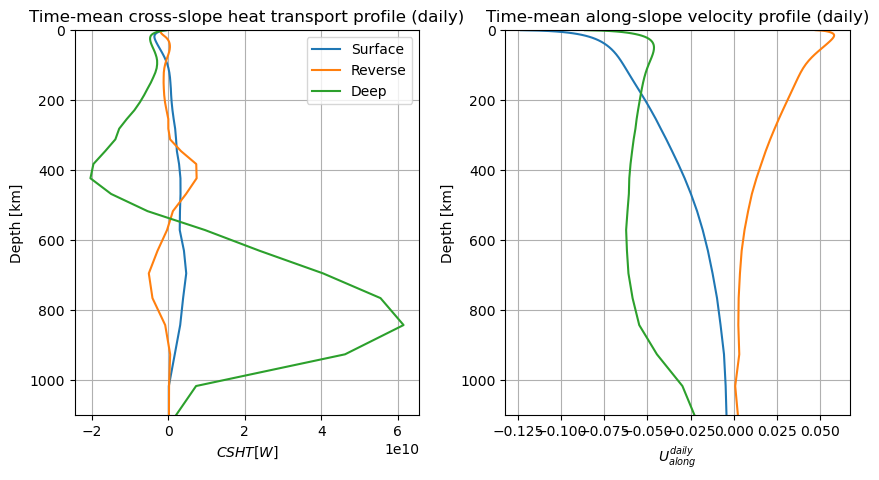

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT_day.isel(regime=0).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT_day.isel(regime=1).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT_day.isel(regime=2).mean('lon').mean('time').plot(ax=axs[0], y='depth', label = classes[2])

masked_u_alongday.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[0])
masked_u_alongday.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[1])
masked_u_alongday.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[1], y='depth', label = classes[2])


axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile (daily)')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_title('Time-mean along-slope velocity profile (daily)')
axs[1].set_ylim(1100,0)
axs[1].set_ylabel('Depth [km]')
axs[1].set_xlabel('$U_{along}^{daily}$')

plt.savefig('/home/156/wf4500/x77_wf4500/ASC_project/analysis_figs/daily_CSHT_vs_Ualong_time_mean.png', dpi=300, bbox_inches='tight')
plt.show()


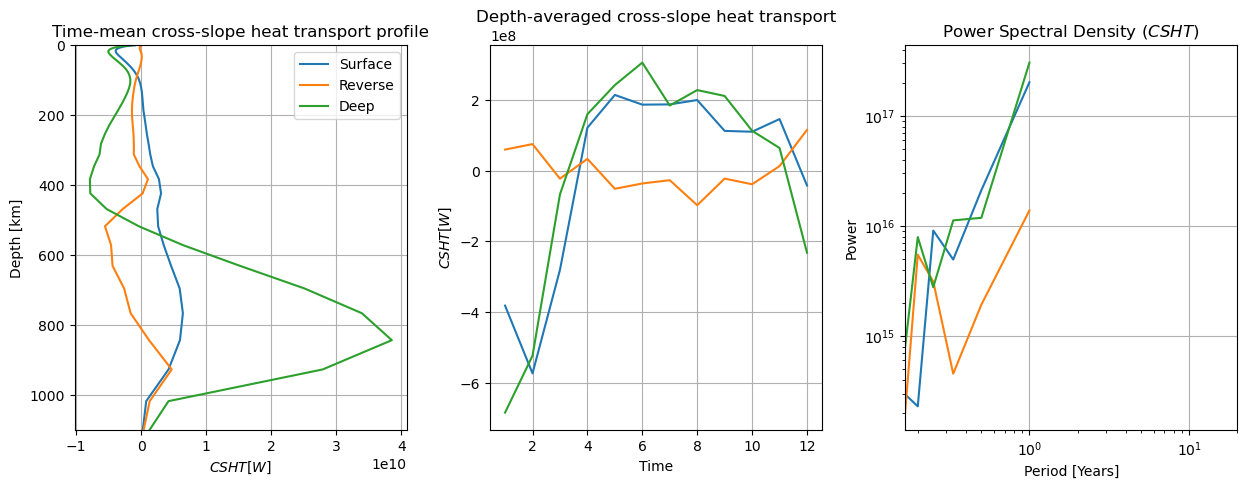

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_CSHT.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_CSHT.groupby('time.month').mean('time').isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].grid()
axs[1].set_title('Depth-averaged cross-slope heat transport')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$CSHT [W]$')

axs[2].set_title('Power Spectral Density ($CSHT$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/CSHT_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


now daily data

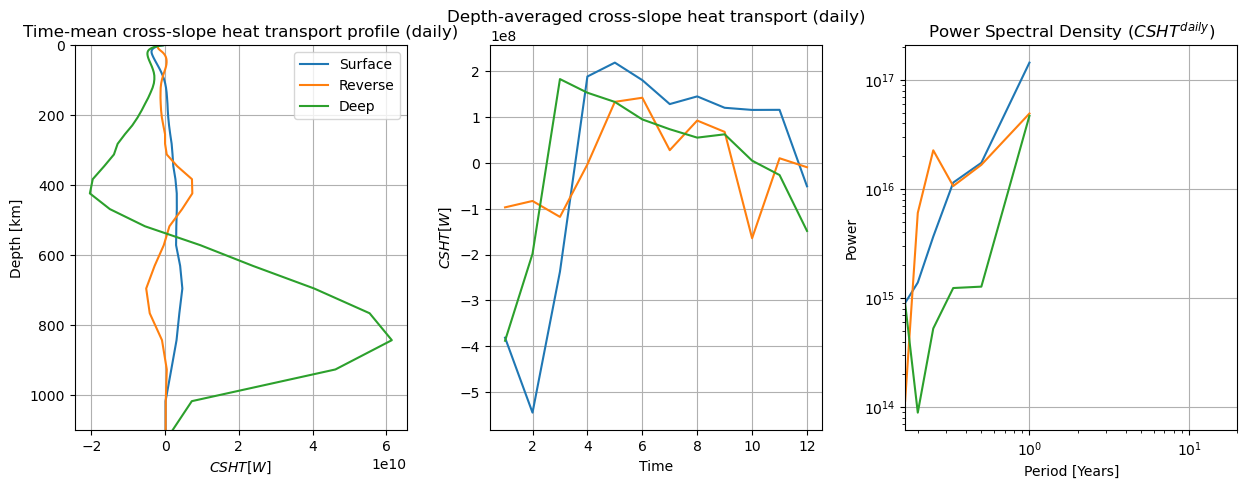

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

masked_CSHT_day.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[0])
masked_CSHT_day.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[1])
masked_CSHT_day.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('month').plot(ax=axs[0], y='depth', label = classes[2])

(masked_CSHT_day.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth')-\
 masked_CSHT_day.groupby('time.month').mean('time').isel(regime=0).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[0])
(masked_CSHT_day.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth')-\
 masked_CSHT_day.groupby('time.month').mean('time').isel(regime=1).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[1])
(masked_CSHT_day.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth')-\
 masked_CSHT_day.groupby('time.month').mean('time').isel(regime=2).mean('lon').mean('depth').mean('month')).plot(ax=axs[1], label = classes[2])

for j in range(3):
    # Compute the power spectral density
    frequencies, psd = signal.welch(masked_CSHT_day.groupby('time.month').mean('time').isel(regime=j).mean('lon').mean('depth').values, fs=1)
    axs[2].loglog(1/frequencies/12, psd, label = classes[j])

axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_title('Time-mean cross-slope heat transport profile (daily)')
axs[0].legend()
axs[0].set_ylim(1100,0)
axs[0].set_ylabel('Depth [km]')
axs[0].set_xlabel('$CSHT [W]$')

axs[1].grid()
axs[1].set_title('Depth-averaged cross-slope heat transport (daily)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('$CSHT [W]$')

axs[2].set_title('Power Spectral Density ($CSHT^{daily}$)')
axs[2].set_xlabel('Period [Years]')
axs[2].set_ylabel('Power')
axs[2].set_xlim(2/12,20)
axs[2].grid()
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/CSHT_masked_clusters_seasonal.png', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
## Average over different time scales to get depth-based correlations
CSHT_annual = masked_CSHT.mean('lon').groupby('time.year').mean('time')
U_along_annual = masked_u_along.mean('lon').groupby('time.year').mean('time')

CSHT_clima = masked_CSHT.groupby('time.month').mean('time').mean('lon')
U_along_clima = masked_u_along.groupby('time.month').mean('time').mean('lon')

CSHT_layerwise = masked_CSHT.mean('lon')
U_along_layerwise = masked_u_along.mean('lon')


CSHT_day = masked_CSHT_day.mean('lon')
U_along_day = masked_u_alongday.mean('lon')

In [42]:
slope_all = np.zeros((masked_u_along.depth.size, 3))
p_all = np.zeros((masked_u_along.depth.size, 3))
p_annual = np.zeros((masked_u_along.depth.size, 3))
stderr_all = np.zeros((masked_u_along.depth.size, 3))
r_sq_all = np.zeros((masked_u_along.depth.size, 3))
slope_annual = np.zeros((masked_u_along.depth.size, 3))
stderr_annual = np.zeros((masked_u_along.depth.size, 3))
r_sq_annual = np.zeros((masked_u_along.depth.size, 3))
slope_day = np.zeros((masked_u_alongday.depth.size, 3))
stderr_day = np.zeros((masked_u_alongday.depth.size, 3))
r_sq_day = np.zeros((masked_u_alongday.depth.size, 3))
# slope_deseasoned = np.zeros((masked_u_along.depth.size, 3))
# stderr_deseasoned = np.zeros((masked_u_along.depth.size, 3))
# r_sq_deseasoned = np.zeros((masked_u_along.depth.size, 3))
slope_clima = np.zeros((masked_u_along.depth.size, 3))
stderr_clima = np.zeros((masked_u_along.depth.size, 3))
r_sq_clima = np.zeros((masked_u_along.depth.size, 3))
pval_all = np.zeros((masked_u_along.depth.size, 3))
pval_annual = np.zeros((masked_u_along.depth.size, 3))
pval_clima = np.zeros((masked_u_along.depth.size, 3))
p_clima = np.zeros((masked_u_along.depth.size, 3))
pval_day = np.zeros((masked_u_alongday.depth.size, 3))
p_day = np.zeros((masked_u_alongday.depth.size, 3))

for i in range(3):
    for j in range(masked_u_along.depth.size):
        slope_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
        stderr_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
        p_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue
        r_sq_all[j,i] = stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
        pval_all[j,i] = 1-stats.linregress(U_along_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).pvalue
        slope_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).slope
        stderr_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).stderr
        p_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).pvalue
        r_sq_annual[j,i] = stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).rvalue**2
        pval_annual[j,i] = 1-stats.linregress(U_along_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).pvalue
        slope_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).slope
        stderr_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).stderr
        r_sq_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).rvalue**2
        pval_clima[j,i] = 1-stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).pvalue
        p_clima[j,i] = stats.linregress(U_along_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).pvalue

        slope_day[j,i] = stats.linregress(U_along_day[:,j,i][~np.isnan(CSHT_day[:,j,i])], CSHT_day[:,j,i][~np.isnan(CSHT_day[:,j,i])]/1e12).slope
        stderr_day[j,i] = stats.linregress(U_along_day[:,j,i][~np.isnan(CSHT_day[:,j,i])], CSHT_day[:,j,i][~np.isnan(CSHT_day[:,j,i])]/1e12).stderr
        r_sq_day[j,i] = stats.linregress(U_along_day[:,j,i][~np.isnan(CSHT_day[:,j,i])], CSHT_day[:,j,i][~np.isnan(CSHT_day[:,j,i])]/1e12).rvalue**2
        pval_day[j,i] = 1-stats.linregress(U_along_day[:,j,i][~np.isnan(CSHT_day[:,j,i])], CSHT_day[:,j,i][~np.isnan(CSHT_day[:,j,i])]/1e12).pvalue
        p_day[j,i] = stats.linregress(U_along_day[:,j,i][~np.isnan(CSHT_day[:,j,i])], CSHT_day[:,j,i][~np.isnan(CSHT_day[:,j,i])]/1e12).pvalue




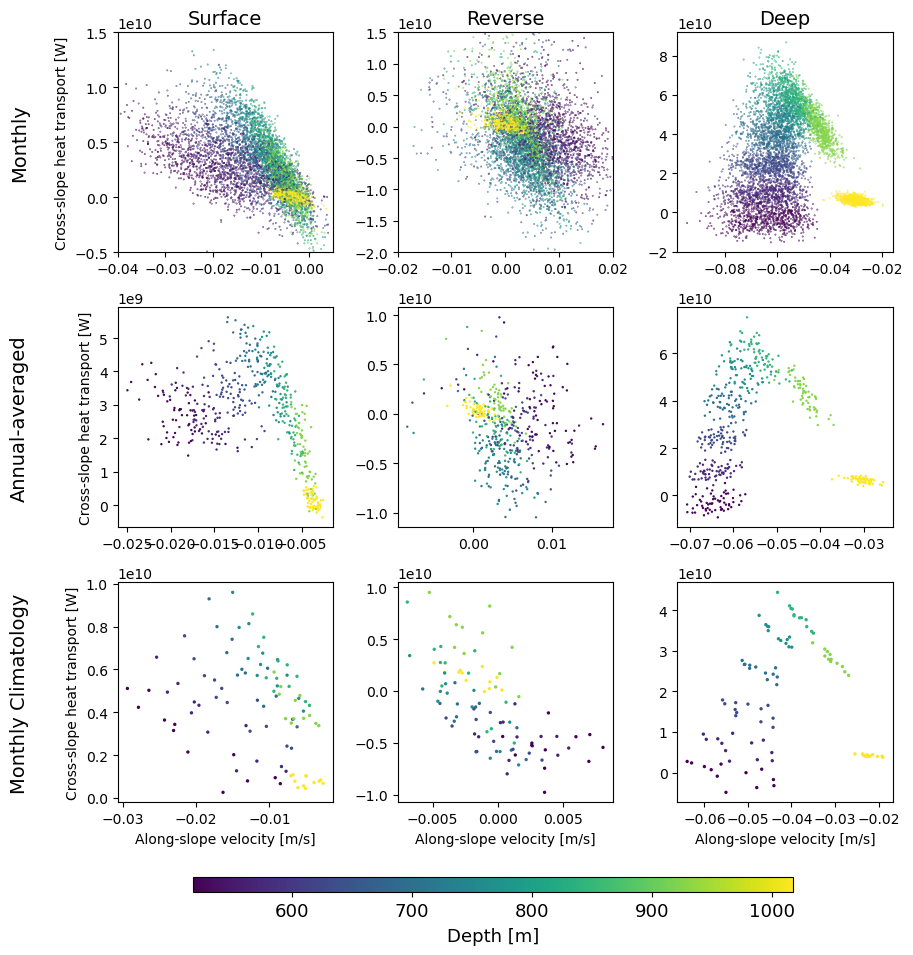

In [43]:
depth_tiled_layerwise = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_layerwise.time.size, axis=0)
depth_tiled_annual = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_annual.year.size, axis=0)
depth_tiled_clima = np.repeat(masked_u_along.depth.values[np.newaxis,:], U_along_clima.month.size, axis=0)


fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.25, wspace=0.3)

for i in range(3):
    im = axs[i].scatter(U_along_layerwise[:,39:47,i].values.flatten(), CSHT_layerwise[:,39:47,i].values.flatten(), 0.1, c = depth_tiled_layerwise[:,39:47].flatten())
    im = axs[i+3].scatter(U_along_annual[:,39:47,i].values.flatten(), CSHT_annual[:,39:47,i].values.flatten(), 0.5, c = depth_tiled_annual[:,39:47].flatten())
    im = axs[i+6].scatter(U_along_clima[:,39:47,i].values.flatten(), CSHT_clima[:,39:47,i].values.flatten(), 2, c = depth_tiled_clima[:,39:47].flatten())

    axs[i].set_title(classes[i], fontsize=14)
axs[0].set_xlim(-0.04,0.005)
axs[0].set_ylim(-0.5e10,1.5e10)
axs[1].set_xlim(-0.02,0.02)
axs[1].set_ylim(-2e10,1.5e10)
# axs[2].set_xlim(-0.1,0.02)
# axs[2].set_ylim(-2e10,5.5e10)

cbaxes = fig.add_axes([0.2, 0.02, 0.6, 0.015])
cbar = plt.colorbar(im, cax = cbaxes, orientation = 'horizontal')
cbar.set_label(r'Depth [m]', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)

axs[0].text(-0.5,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[6].text(-0.5,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
axs[3].text(-0.5,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

axs[0].set_ylabel('Cross-slope heat transport [W]')
axs[3].set_ylabel('Cross-slope heat transport [W]')
axs[6].set_ylabel('Cross-slope heat transport [W]')

axs[6].set_xlabel('Along-slope velocity [m/s]')
axs[7].set_xlabel('Along-slope velocity [m/s]')
axs[8].set_xlabel('Along-slope velocity [m/s]')

#plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/Scatter_plots_regimes.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
########################### Regime 0 - surface #######################

# u speed ##########################################
####Daily mean
u_reg0d=masked_u_alongday.isel(regime=0).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg0=masked_u_along.isel(regime=0).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg0Y=masked_u_along.isel(regime=0).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg0C=masked_u_along.isel(regime=0).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
#rsquare for transparency ###########################
####Daily mean
alphas_reg0d=masked_u_alongday.isel(regime=0).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_day[:,0],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg0d = np.array((alphas_reg0d.where(alphas_reg0d>0.5)*0) +1) ;r_reg00d=u_reg0d.copy(); r_reg00d.values=r_reg0d
####Monthly mean
alphas_reg0=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_all[:,0],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg0 = np.array((alphas_reg0.where(alphas_reg0>0.5)*0) +1) ;r_reg00=u_reg0.copy(); r_reg00.values=r_reg0
####Yearly mean
alphas_reg0Y=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').resample(time='1Y').mean()\
    .expand_dims(rsquare=np.nan_to_num(r_sq_annual[:,0],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg0Y = np.array((alphas_reg0Y.where(alphas_reg0Y>0.5)*0) +1) ;r_reg00Y=u_reg0Y.copy(); r_reg00Y.values=r_reg0Y
####Climatology
alphas_reg0C=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').groupby('time.month').mean().rename({'month':'time'})\
    .expand_dims(rsquare=np.nan_to_num(r_sq_clima[:,0],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg0C = np.array((alphas_reg0C.where(alphas_reg0C>0.5)*0) +1) ;r_reg00C=u_reg0C.copy(); r_reg00C.values=r_reg0C
#monthly mean p for filtering ##########################
####daily mean
p_reg0d=masked_u_alongday.isel(regime=0).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_day[:,0],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg0d=np.array((p_reg0d.where(p_reg0d<0.05)*0) +1) ; p_reg00d=u_reg0d.copy() ; p_reg00d.values=p_reg0d
####Monthly mean
p_reg0=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_all[:,0],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg0=np.array((p_reg0.where(p_reg0<0.05)*0) +1) ; p_reg00=u_reg0.copy() ; p_reg00.values=p_reg0
####Yearly mean
p_reg0Y=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').resample(time='1Y').mean().\
expand_dims(p_value=np.nan_to_num(p_annual[:,0],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg0Y=np.array((p_reg0Y.where(p_reg0Y<0.05)*0) +1) ; p_reg00Y=u_reg0Y.copy() ; p_reg00Y.values=p_reg0Y
####Climatology
p_reg0C=masked_u_along.isel(regime=0).\
mean('lon').mean('depth').groupby('time.month').mean()\
.rename({'month':'time'}).expand_dims(p_value=np.nan_to_num(p_clima[:,0],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg0C=np.array((p_reg0C.where(p_reg0C<0.05)*0) +1) ; p_reg00C=u_reg0C.copy() ; p_reg00C.values=p_reg0C
#Filtering U/HT by R and P ##########################
####Daily mean
u_reg0d=u_reg0d #* p_reg00 * r_reg00
CSHT_reg0d=masked_CSHT_day.isel(regime=0).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg0=u_reg0 #* p_reg00 * r_reg00
CSHT_reg0=masked_CSHT.isel(regime=0).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg0Y=u_reg0Y #* p_reg00Y * r_reg00Y
CSHT_reg0Y=masked_CSHT.isel(regime=0).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg0C=u_reg0C #* p_reg00C * r_reg00C
CSHT_reg0C=masked_CSHT.isel(regime=0).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
colorvector=np.log10(CSHT_reg0.depth)
colorvectorY=np.log10(CSHT_reg0Y.depth)
colorvectorC=np.log10(CSHT_reg0C.depth)
colorvectorD=np.log10(CSHT_reg0d.depth)





In [45]:
########################### Regime 1 - Reversed #######################

# u speed ##########################################
####Monthly mean
u_reg1d=masked_u_alongday.isel(regime=1).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg1=masked_u_along.isel(regime=1).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg1Y=masked_u_along.isel(regime=1).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg1C=masked_u_along.isel(regime=1).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
#rsquare for transparency ###########################
####Daily mean
alphas_reg1d=masked_u_alongday.isel(regime=1).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_day[:,1],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg1d = np.array((alphas_reg1d.where(alphas_reg1d>0.5)*0) +1) ;r_reg11d=u_reg1d.copy(); r_reg11d.values=r_reg1d
####Monthly mean
alphas_reg1=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_all[:,1],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg1 = np.array((alphas_reg1.where(alphas_reg1>0.5)*0) +1) ;r_reg11=u_reg1.copy(); r_reg11.values=r_reg1
####Yearly mean
alphas_reg1Y=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').resample(time='1Y').mean()\
    .expand_dims(rsquare=np.nan_to_num(r_sq_annual[:,1],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg1Y = np.array((alphas_reg1Y.where(alphas_reg1Y>0.5)*0) +1) ;r_reg11Y=u_reg1Y.copy(); r_reg11Y.values=r_reg1Y
####Climatology
alphas_reg1C=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').groupby('time.month').mean().rename({'month':'time'})\
    .expand_dims(rsquare=np.nan_to_num(r_sq_clima[:,1],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg1C = np.array((alphas_reg1C.where(alphas_reg1C>0.5)*0) +1) ;r_reg11C=u_reg1C.copy(); r_reg11C.values=r_reg1C
#monthly mean p for filtering ##########################
####Daily mean
p_reg1d=masked_u_alongday.isel(regime=1).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_day[:,1],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg1d=np.array((p_reg1d.where(p_reg1d<0.05)*0) +1) ; p_reg11d=u_reg1d.copy() ; p_reg11d.values=p_reg1d
####Monthly mean
p_reg1=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_all[:,1],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg1=np.array((p_reg1.where(p_reg1<0.05)*0) +1) ; p_reg11=u_reg1.copy() ; p_reg11.values=p_reg1
####Yearly mean
p_reg1Y=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').resample(time='1Y').mean().\
expand_dims(p_value=np.nan_to_num(p_annual[:,1],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg1Y=np.array((p_reg1Y.where(p_reg1Y<0.05)*0) +1) ; p_reg11Y=u_reg1Y.copy() ; p_reg11Y.values=p_reg1Y
####Climatology
p_reg1C=masked_u_along.isel(regime=1).\
mean('lon').mean('depth').groupby('time.month').mean()\
.rename({'month':'time'}).expand_dims(p_value=np.nan_to_num(p_clima[:,1],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg1C=np.array((p_reg1C.where(p_reg1C<0.05)*0) +1) ; p_reg11C=u_reg1C.copy() ; p_reg11C.values=p_reg1C
#Filtering U/HT by R and P ##########################
####Monthly mean
u_reg1d=u_reg1d #* p_reg11d * r_reg11d
CSHT_reg1d=masked_CSHT_day.isel(regime=1).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg1=u_reg1 #* p_reg11 * r_reg11
CSHT_reg1=masked_CSHT.isel(regime=1).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg1Y=u_reg1Y #* p_reg11Y * r_reg11Y
CSHT_reg1Y=masked_CSHT.isel(regime=1).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg1C=u_reg1C #* p_reg11C * r_reg11C
CSHT_reg1C=masked_CSHT.isel(regime=1).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
colorvector1=np.log10(CSHT_reg1.depth)
colorvector1Y=np.log10(CSHT_reg1Y.depth)
colorvector1C=np.log10(CSHT_reg1C.depth)
colorvector1d=np.log10(CSHT_reg1d.depth)


In [46]:
########################### Regime 2 - Deep #######################

# u speed ##########################################
####Monthly mean
u_reg2d=masked_u_alongday.isel(regime=2).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg2=masked_u_along.isel(regime=2).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg2Y=masked_u_along.isel(regime=2).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg2C=masked_u_along.isel(regime=2).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
#rsquare for transparency ###########################
####Daily mean
alphas_reg2d=masked_u_alongday.isel(regime=2).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_day[:,2],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg2d = np.array((alphas_reg2d.where(alphas_reg2d>0.5)*0) +1) ;r_reg22d=u_reg2d.copy(); r_reg22d.values=r_reg2d
####Monthly mean
alphas_reg2=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').expand_dims(rsquare=np.nan_to_num(r_sq_all[:,2],nan=0)).\
stack(points=('time','rsquare')).rsquare
r_reg2 = np.array((alphas_reg2.where(alphas_reg2>0.5)*0) +1) ;r_reg22=u_reg2.copy(); r_reg22.values=r_reg2
####Yearly mean
alphas_reg2Y=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').resample(time='1Y').mean()\
    .expand_dims(rsquare=np.nan_to_num(r_sq_annual[:,2],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg2Y = np.array((alphas_reg2Y.where(alphas_reg2Y>0.5)*0) +1) ;r_reg22Y=u_reg2Y.copy(); r_reg22Y.values=r_reg2Y
####Climatology
alphas_reg2C=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').groupby('time.month').mean().rename({'month':'time'})\
    .expand_dims(rsquare=np.nan_to_num(r_sq_clima[:,2],nan=0)).\
        stack(points=('time','rsquare')).rsquare
r_reg2C = np.array((alphas_reg2C.where(alphas_reg2C>0.5)*0) +1) ;r_reg22C=u_reg2C.copy(); r_reg22C.values=r_reg2C
#monthly mean p for filtering ##########################
####Daily mean
p_reg2d=masked_u_alongday.isel(regime=2).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_day[:,2],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg2d=np.array((p_reg2d.where(p_reg2d<0.05)*0) +1) ; p_reg22d=u_reg2d.copy() ; p_reg22d.values=p_reg2d
####Monthly mean
p_reg2=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').expand_dims(p_value=np.nan_to_num(p_all[:,2],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg2=np.array((p_reg2.where(p_reg2<0.05)*0) +1) ; p_reg22=u_reg2.copy() ; p_reg22.values=p_reg2
####Yearly mean
p_reg2Y=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').resample(time='1Y').mean().\
expand_dims(p_value=np.nan_to_num(p_annual[:,2],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg2Y=np.array((p_reg2Y.where(p_reg2Y<0.05)*0) +1) ; p_reg22Y=u_reg2Y.copy() ; p_reg22Y.values=p_reg2Y
####Climatology
p_reg2C=masked_u_along.isel(regime=2).\
mean('lon').mean('depth').groupby('time.month').mean()\
.rename({'month':'time'}).expand_dims(p_value=np.nan_to_num(p_clima[:,2],nan=0)).\
stack(points=('time','p_value')).p_value
p_reg2C=np.array((p_reg2C.where(p_reg2C<0.05)*0) +1) ; p_reg22C=u_reg2C.copy() ; p_reg22C.values=p_reg2C
#Filtering U/HT by R and P ##########################
####Daily mean
u_reg2d=u_reg2d #* p_reg22d * r_reg22d
CSHT_reg2d=masked_CSHT_day.isel(regime=2).mean('lon').stack(points=('time','depth'))
####Monthly mean
u_reg2=u_reg2 #* p_reg22 * r_reg22
CSHT_reg2=masked_CSHT.isel(regime=2).mean('lon').stack(points=('time','depth'))
####Yearly mean
u_reg2Y=u_reg2Y #* p_reg22Y * r_reg22Y
CSHT_reg2Y=masked_CSHT.isel(regime=2).mean('lon').resample(time='1Y').mean().stack(points=('time','depth'))
####Climatology
u_reg2C=u_reg2C #* p_reg22C * r_reg22C
CSHT_reg2C=masked_CSHT.isel(regime=2).mean('lon').groupby('time.month').mean()\
    .rename({'month':'time'}).stack(points=('time','depth'))
colorvector2=np.log10(CSHT_reg2.depth)
colorvector2Y=np.log10(CSHT_reg2Y.depth)
colorvector2C=np.log10(CSHT_reg2C.depth)
colorvector2d=np.log10(CSHT_reg2d.depth)

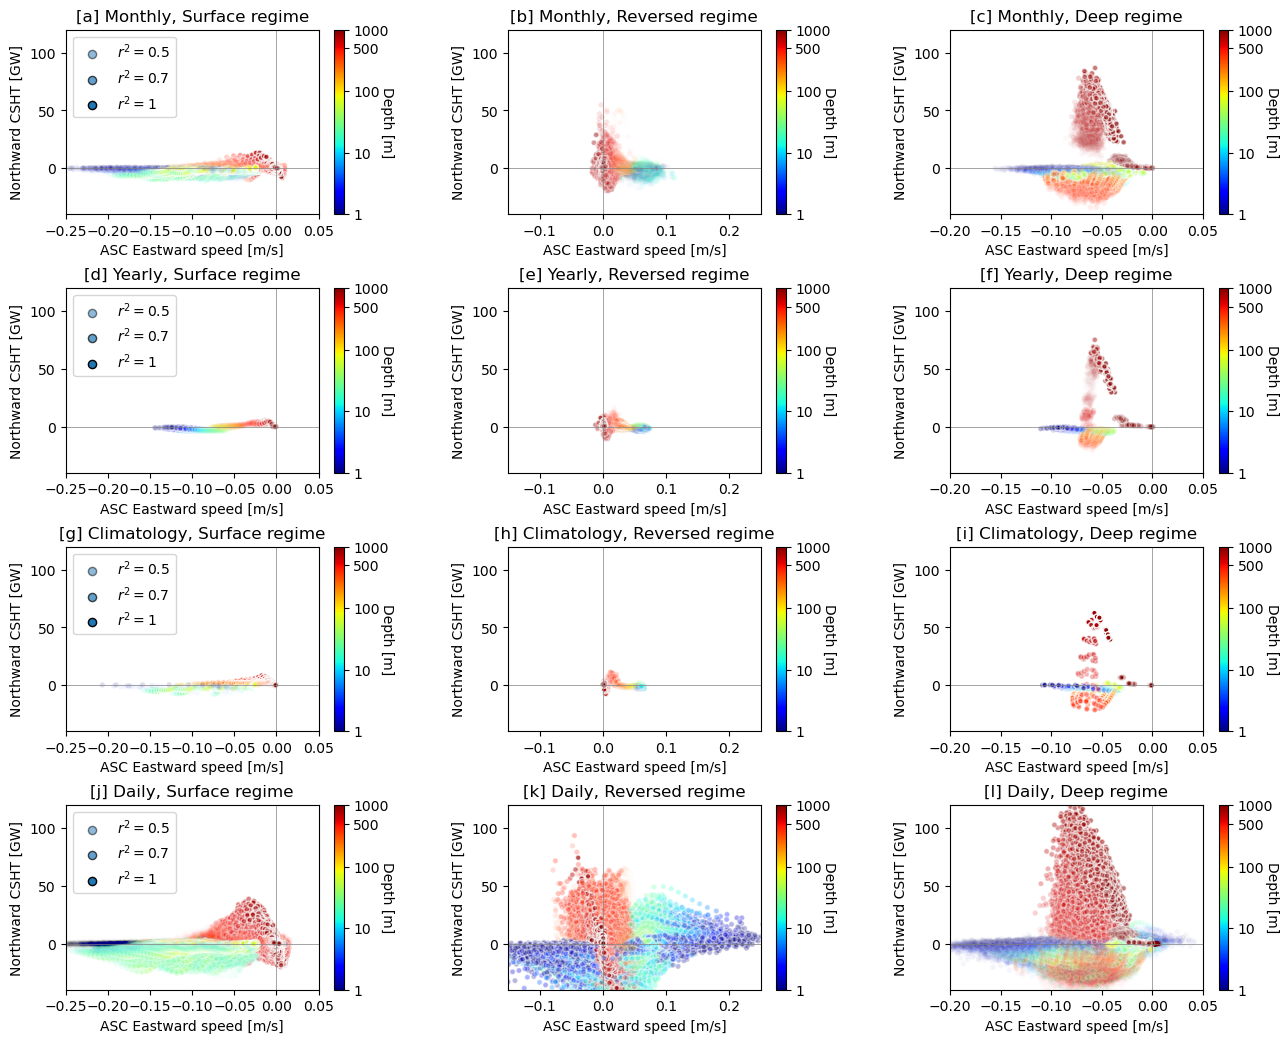

In [47]:
### Scatter plots of regimes
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ymax=120
ymin=-40

####### SURFACE REGIMES ######################################################################
plt.subplot(4,3,1)
sc = plt.scatter(u_reg0,CSHT_reg0/1e9,c=colorvector,cmap='jet',s=15,alpha=alphas_reg0,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(sc, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[a] Monthly, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,4)
scY = plt.scatter(u_reg0Y,CSHT_reg0Y/1e9,c=colorvectorY,cmap='jet',s=15,alpha=alphas_reg0Y,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[d] Yearly, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,7)
scY = plt.scatter(u_reg0C,CSHT_reg0C/1e9,c=colorvectorC,cmap='jet',s=15,alpha=alphas_reg0C,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[g] Climatology, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,10)
scd = plt.scatter(u_reg0d,CSHT_reg0d/1e9,c=colorvectorD,cmap='jet',s=15,alpha=alphas_reg0d,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scd, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[j] Daily, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()

####### REVERSED REGIME ######################################################################
plt.subplot(4,3,2)
sc1 = plt.scatter(u_reg1,CSHT_reg1/1e9,c=colorvector1,cmap='jet',s=15,alpha=alphas_reg1,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[b] Monthly, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.15,0.25)

plt.subplot(4,3,5)
sc1Y = plt.scatter(u_reg1Y,CSHT_reg1Y/1e9,c=colorvector1Y,cmap='jet',s=15,alpha=alphas_reg1Y,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1Y, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[e] Yearly, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.15,0.25)

plt.subplot(4,3,8)
sc1C = plt.scatter(u_reg1C,CSHT_reg1C/1e9,c=colorvector1C,cmap='jet',s=15,alpha=alphas_reg1C,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1C, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[h] Climatology, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.15,0.25)

plt.subplot(4,3,11)
sc1d = plt.scatter(u_reg1d,CSHT_reg1d/1e9,c=colorvector1d,cmap='jet',s=15,alpha=alphas_reg1d,vmin=0,vmax=3,edgecolor='white')
cbar1d = plt.colorbar(sc1d, ticks=[0,1,2,2.698,3])
cbar1d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1d.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[k] Daily, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.15,0.25)


#######DEEP REGIME ######################################################################
plt.subplot(4,3,3)
sc2 = plt.scatter(u_reg2,CSHT_reg2/1e9,c=colorvector2,cmap='jet',s=15,alpha=alphas_reg2,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[c] Monthly, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.subplot(4,3,6)
sc2Y = plt.scatter(u_reg2Y,CSHT_reg2Y/1e9,c=colorvector2Y,cmap='jet',s=15,alpha=alphas_reg2Y,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2Y, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[f] Yearly, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.subplot(4,3,9)
sc2C = plt.scatter(u_reg2C,CSHT_reg2C/1e9,c=colorvector2C,cmap='jet',s=15,alpha=alphas_reg2C,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2C, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[i] Climatology, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)


plt.subplot(4,3,12)
sc2d = plt.scatter(u_reg2d,CSHT_reg2d/1e9,c=colorvector2d,cmap='jet',s=15,alpha=alphas_reg2d,vmin=0,vmax=3,edgecolor='white')
cbar2d = plt.colorbar(sc2d, ticks=[0,1,2,2.698,3])
cbar2d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2d.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[l] Daily, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/UvsCSHT_scatter.png', bbox_inches='tight', dpi=300)






In [48]:
# Filtering values for plotting only regions with r2>0.5, and significant correlations

#Filtering U/HT by R and P ########################## regime 0 
####Daily mean
u_reg0fd=u_reg0d * p_reg00d * r_reg00d
####Monthly mean
u_reg0f=u_reg0 * p_reg00 * r_reg00
####Yearly mean
u_reg0Yf=u_reg0Y * p_reg00Y * r_reg00Y
####Climatology
u_reg0Cf=u_reg0C * p_reg00C * r_reg00C
#Filtering U/HT by R and P ########################## regime 1
####Monthly mean
u_reg1fd=u_reg1d * p_reg11d * r_reg11d
####Monthly mean
u_reg1f=u_reg1 * p_reg11 * r_reg11
####Yearly mean
u_reg1Yf=u_reg1Y * p_reg11Y * r_reg11Y
####Climatology
u_reg1Cf=u_reg1C * p_reg11C * r_reg11C

#Filtering U/HT by R and P ########################## regime 0 
####Monthly mean
u_reg2fd=u_reg2d * p_reg22d * r_reg22d
####Monthly mean
u_reg2f=u_reg2 * p_reg22 * r_reg22
####Yearly mean
u_reg2Yf=u_reg2Y * p_reg22Y * r_reg22Y
####Climatology
u_reg2Cf=u_reg2C * p_reg22C * r_reg22C

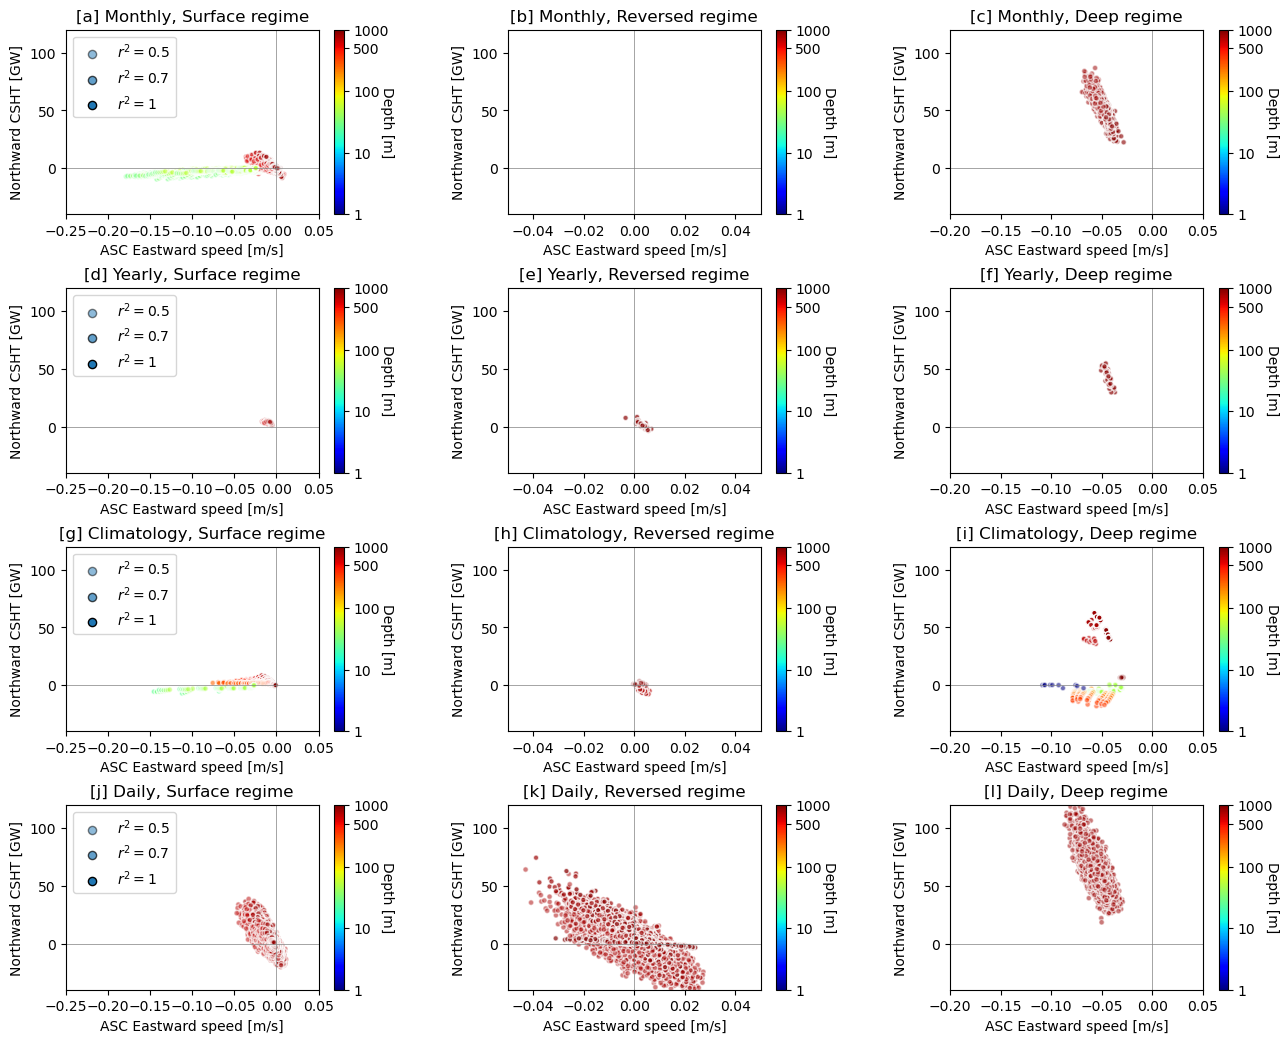

In [49]:
### Scatter plots of regimes
plt.figure(figsize=(15,12))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ymax=120
ymin=-40

####### SURFACE REGIMES ######################################################################
plt.subplot(4,3,1)
sc = plt.scatter(u_reg0f,CSHT_reg0/1e9,c=colorvector,cmap='jet',s=15,alpha=alphas_reg0,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(sc, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[a] Monthly, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,4)
scY = plt.scatter(u_reg0Yf,CSHT_reg0Y/1e9,c=colorvectorY,cmap='jet',s=15,alpha=alphas_reg0Y,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[d] Yearly, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,7)
scY = plt.scatter(u_reg0Cf,CSHT_reg0C/1e9,c=colorvectorC,cmap='jet',s=15,alpha=alphas_reg0C,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[g] Climatology, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()


plt.subplot(4,3,10)
scd = plt.scatter(u_reg0fd,CSHT_reg0d/1e9,c=colorvectorD,cmap='jet',s=15,alpha=alphas_reg0d,vmin=0,vmax=3,edgecolor='white')
cbar = plt.colorbar(scd, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[j] Daily, Surface regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.25,0.05)
plt.legend()

####### REVERSED REGIME ######################################################################
plt.subplot(4,3,2)
sc1 = plt.scatter(u_reg1f,CSHT_reg1/1e9,c=colorvector1,cmap='jet',s=15,alpha=alphas_reg1,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[b] Monthly, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.05,0.05)

plt.subplot(4,3,5)
sc1Y = plt.scatter(u_reg1Yf,CSHT_reg1Y/1e9,c=colorvector1Y,cmap='jet',s=15,alpha=alphas_reg1Y,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1Y, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[e] Yearly, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.05,0.05)

plt.subplot(4,3,8)
sc1C = plt.scatter(u_reg1Cf,CSHT_reg1C/1e9,c=colorvector1C,cmap='jet',s=15,alpha=alphas_reg1C,vmin=0,vmax=3,edgecolor='white')
cbar1 = plt.colorbar(sc1C, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[h] Climatology, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.05,0.05)

plt.subplot(4,3,11)
sc1d = plt.scatter(u_reg1fd,CSHT_reg1d/1e9,c=colorvector1d,cmap='jet',s=15,alpha=alphas_reg1d,vmin=0,vmax=3,edgecolor='white')
cbar1d = plt.colorbar(sc1d, ticks=[0,1,2,2.698,3])
cbar1d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1d.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[k] Daily, Reversed regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.05,0.05)


#######DEEP REGIME ######################################################################
plt.subplot(4,3,3)
sc2 = plt.scatter(u_reg2f,CSHT_reg2/1e9,c=colorvector2,cmap='jet',s=15,alpha=alphas_reg2,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[c] Monthly, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.subplot(4,3,6)
sc2Y = plt.scatter(u_reg2Yf,CSHT_reg2Y/1e9,c=colorvector2Y,cmap='jet',s=15,alpha=alphas_reg2Y,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2Y, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[f] Yearly, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.subplot(4,3,9)
sc2C = plt.scatter(u_reg2Cf,CSHT_reg2C/1e9,c=colorvector2C,cmap='jet',s=15,alpha=alphas_reg2C,vmin=0,vmax=3,edgecolor='white')
cbar2 = plt.colorbar(sc2C, ticks=[0,1,2,2.698,3])
cbar2.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[i] Climatology, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)


plt.subplot(4,3,12)
sc2d = plt.scatter(u_reg2fd,CSHT_reg2d/1e9,c=colorvector2d,cmap='jet',s=15,alpha=alphas_reg2d,vmin=0,vmax=3,edgecolor='white')
cbar2d = plt.colorbar(sc2d, ticks=[0,1,2,2.698,3])
cbar2d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar2d.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.3,s=35,edgecolor='black',label=r"$r^{2}=0.3$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[l] Daily, Deep regime')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/UvsCSHT_filteredscatter.png', bbox_inches='tight', dpi=300)



Interestingly, it seems like nothing is significant in the daily regime. is that correct?

Based on the plot above, I think we can draw 3 panels, one for each timescale, and each figure drawing 3 regimes. lets see how it would go.

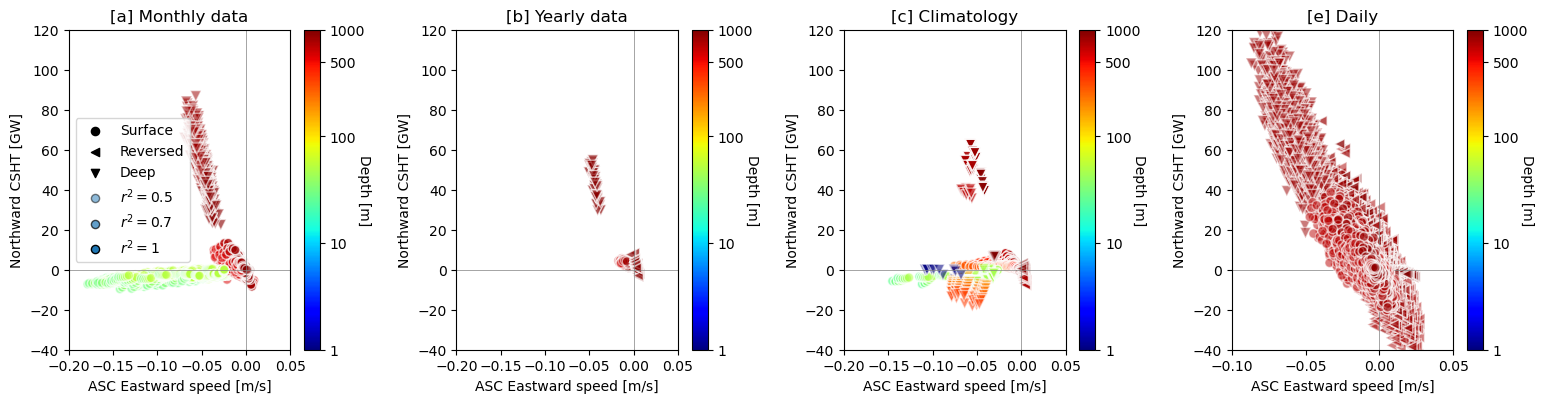

In [50]:
### Scatter plots of regimes
plt.figure(figsize=(18,4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

cmapname='jet'
####### Monthly plot ##################################################################################
plt.subplot(1,4,1)
#Surface regime
sc = plt.scatter(u_reg0f,CSHT_reg0/1e9,c=colorvector,cmap=cmapname,s=45,\
                 alpha=alphas_reg0,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'o') 
# Reversed regime
sc1 = plt.scatter(u_reg1f,CSHT_reg1/1e9,c=colorvector1,cmap=cmapname,s=55,\
                  alpha=alphas_reg1,vmin=0,vmax=3,\
                    edgecolor='white',marker= "<")
# deep regime
sc2 = plt.scatter(u_reg2f,CSHT_reg2/1e9,c=colorvector2,cmap=cmapname,s=60,\
                  alpha=alphas_reg2,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar = plt.colorbar(sc, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= 'o',label='Surface')
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= "<",label='Reversed')
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= 'v',label='Deep')
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")


plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[a] Monthly data')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)
plt.legend()


####### Yearly plot ##################################################################################
plt.subplot(1,4,2)
scY = plt.scatter(u_reg0Yf,CSHT_reg0Y/1e9,c=colorvectorY,cmap=cmapname,s=45,\
                  alpha=alphas_reg0Y,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'o')
sc1Y = plt.scatter(u_reg1Yf,CSHT_reg1Y/1e9,c=colorvector1Y,cmap=cmapname,s=55,\
                   alpha=alphas_reg1Y,vmin=0,vmax=3,\
                    edgecolor='white',marker= "<")
sc2Y = plt.scatter(u_reg2Yf,CSHT_reg2Y/1e9,c=colorvector2Y,cmap=cmapname,s=60,\
                   alpha=alphas_reg2Y,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'v')

cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[b] Yearly data')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)
#plt.legend()

####### Climatological plot ##################################################################################
plt.subplot(1,4,3)
sc0C = plt.scatter(u_reg0Cf,CSHT_reg0C/1e9,c=colorvectorC,cmap=cmapname,s=45,\
                   alpha=alphas_reg0C,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'o')
sc1C = plt.scatter(u_reg1Cf,CSHT_reg1C/1e9,c=colorvector1C,cmap=cmapname,s=55,\
                   alpha=alphas_reg1C,vmin=0,vmax=3,\
                   edgecolor='white',marker= '<')
sc2C = plt.scatter(u_reg2Cf,CSHT_reg2C/1e9,c=colorvector2C,cmap=cmapname,s=60,\
                   alpha=alphas_reg2C,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar1 = plt.colorbar(sc1C, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[c] Climatology')
plt.ylim(ymin,ymax)
plt.xlim(-0.2,0.05)

####### daily plot ##################################################################################
plt.subplot(1,4,4)
sc0d = plt.scatter(u_reg0fd,CSHT_reg0d/1e9,c=colorvectorD,cmap=cmapname,s=45,\
                   alpha=alphas_reg0d,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'o',zorder=3)
sc1d = plt.scatter(u_reg1fd,CSHT_reg1d/1e9,c=colorvector1d,cmap=cmapname,s=55,\
                   alpha=alphas_reg1d,vmin=0,vmax=3,\
                   edgecolor='white',marker= '<')
sc2d = plt.scatter(u_reg2fd,CSHT_reg2d/1e9,c=colorvector2d,cmap=cmapname,s=60,\
                   alpha=alphas_reg2d,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar1d = plt.colorbar(sc1d, ticks=[0,1,2,2.698,3])
cbar1d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1d.set_label('Depth [m]', rotation=270)
plt.plot([0,0],[-150,150],color='grey',lw=0.5)
plt.plot([-150,150],[0,0],color='grey',lw=0.5)
plt.scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
plt.scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
plt.scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
plt.xlabel('ASC Eastward speed [m/s]')
plt.ylabel('Northward CSHT [GW]')
plt.title('[e] Daily')
plt.ylim(ymin,ymax)
plt.xlim(-0.1,0.05)



plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/UvsCSHT_simplifiedscatter.png', bbox_inches='tight', dpi=300)



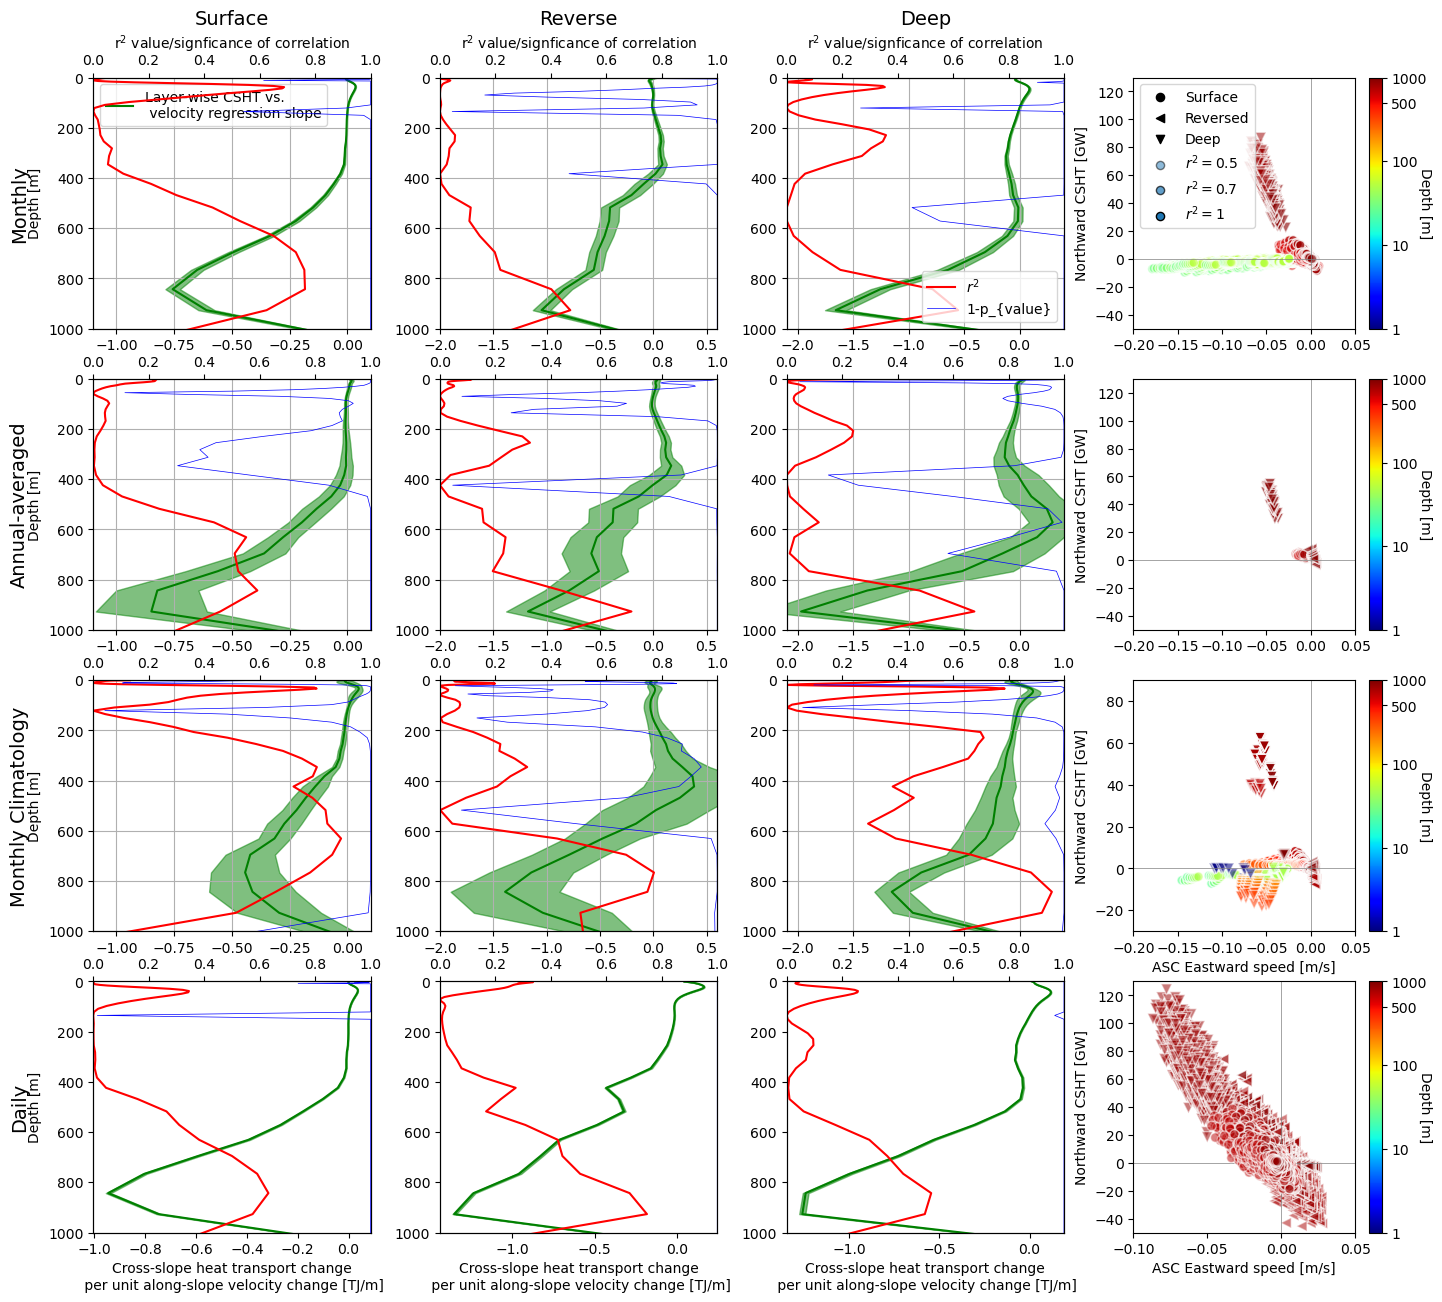

In [51]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(17,15))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)
ymin=-50; ymax=130
for i in range(3):
    axs[i+4].plot(slope_annual[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+4].fill_betweenx( masked_u_along.depth,  slope_annual[:,i]-stderr_annual[:,i]*2, slope_annual[:,i]+stderr_annual[:,i]*2, alpha=0.5, color='green')
    axs[i].plot(slope_all[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i].fill_betweenx( masked_u_along.depth,  slope_all[:,i]-stderr_all[:,i]*2, slope_all[:,i]+stderr_all[:,i]*2, alpha=0.5, color='green')
    axs[i+8].plot(slope_clima[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+8].fill_betweenx(masked_u_along.depth, slope_clima[:,i]-stderr_clima[:,i]*2, slope_clima[:,i]+stderr_clima[:,i]*2, alpha=0.5, color='green')
    axs[i+12].plot(slope_day[:,i], masked_u_alongday.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
    axs[i+12].fill_betweenx(masked_u_alongday.depth, slope_day[:,i]-stderr_day[:,i]*2, slope_day[:,i]+stderr_day[:,i]*2, alpha=0.5, color='green')

    axs[i].set_title(classes[i], fontsize=14)
    ax1 = axs[i].twiny()
    ax2 = axs[i+4].twiny()
    ax3 = axs[i+8].twiny()
    ax4 = axs[i+12].twiny()

    ax1.set_xlim(0,1)
    ax1.set_ylim(1000,0)
    ax1.set_xlabel('r$^2$ value/signficance of correlation')
    ax1.plot(r_sq_all[:,i], masked_u_along.depth, 'r', label = r'$r^2$')
    ax1.plot(pval_all[:,i], masked_u_along.depth, 'b', lw=0.5, label = r'1-p_{value}')
    ax2.set_xlim(0,1)
    ax2.set_ylim(1000,0)
    ax2.plot(r_sq_annual[:,i], masked_u_along.depth, 'r', label = r'$r^2$')
    ax2.plot(pval_annual[:,i], masked_u_along.depth, 'b', lw=0.5,label = r'1-p_{value}')
    ax3.set_xlim(0,1)
    ax3.set_ylim(1000,0)
    ax3.plot(r_sq_clima[:,i], masked_u_along.depth, 'r', label = r'$r^2$')
    ax3.plot(pval_clima[:,i], masked_u_along.depth, 'b', lw=0.5, label = r'1-p_{value}')

    ax4.set_xlim(0,1)
    ax4.set_ylim(1000,0)
    ax4.plot(r_sq_day[:,i], masked_u_alongday.depth, 'r', label = r'$r^2$')
    ax4.plot(pval_day[:,i], masked_u_alongday.depth, 'b', lw=0.5, label = r'1-p_{value}')


    axs[0].set_ylabel('Depth [m]')
    axs[4].set_ylabel('Depth [m]')
    axs[8].set_ylabel('Depth [m]')
    axs[12].set_ylabel('Depth [m]')

    axs[i+12].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
    axs[i].invert_yaxis()
    axs[i].set_ylim(1000,0)
    axs[4*i].set_xlim(-1.1,0.1)
    axs[4*i+1].set_xlim(-2,0.6)
    axs[4*i+2].set_xlim(-2.1,0.4)

    axs[i].grid()
    axs[i+4].invert_yaxis()
    axs[i+4].set_ylim(1000,0)
    axs[i+4].grid()
    axs[i+8].invert_yaxis()
    axs[i+8].set_ylim(1000,0)
    axs[i+8].grid()
    axs[0].legend()

axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
axs[8].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[8].transAxes)
axs[4].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[4].transAxes)
axs[12].text(-0.3,0.5, 'Daily', fontsize = 14, rotation=90, va= 'center', transform = axs[12].transAxes)

######Scatter top
sc = axs[3].scatter(u_reg0f,CSHT_reg0/1e9,c=colorvector,cmap=cmapname,s=45,\
                 alpha=alphas_reg0,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'o') 
# Reversed regime
axs[3].scatter(u_reg1f,CSHT_reg1/1e9,c=colorvector1,cmap=cmapname,s=55,\
                  alpha=alphas_reg1,vmin=0,vmax=3,\
                    edgecolor='white',marker= "<")
# deep regime
axs[3].scatter(u_reg2f,CSHT_reg2/1e9,c=colorvector2,cmap=cmapname,s=60,\
                  alpha=alphas_reg2,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar = plt.colorbar(sc, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
axs[3].plot([0,0],[-150,150],color='grey',lw=0.5)
axs[3].plot([-150,150],[0,0],color='grey',lw=0.5)
axs[3].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= 'o',label='Surface')
axs[3].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= "<",label='Reversed')
axs[3].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',\
            facecolor='black',marker= 'v',label='Deep')
axs[3].scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
axs[3].scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
axs[3].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")


#axis[3].set_xlabel('ASC Eastward speed [m/s]')
axs[3].set_ylabel('Northward CSHT [GW]')
#plt.title('[a] Monthly data')
axs[3].set_ylim(ymin,ymax)
axs[3].set_xlim(-0.2,0.05)
axs[3].legend()

######Scatter middle
scY = axs[7].scatter(u_reg0Yf,CSHT_reg0Y/1e9,c=colorvectorY,cmap=cmapname,s=45,\
                  alpha=alphas_reg0Y,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'o')
axs[7].scatter(u_reg1Yf,CSHT_reg1Y/1e9,c=colorvector1Y,cmap=cmapname,s=55,\
                   alpha=alphas_reg1Y,vmin=0,vmax=3,\
                    edgecolor='white',marker= "<")
axs[7].scatter(u_reg2Yf,CSHT_reg2Y/1e9,c=colorvector2Y,cmap=cmapname,s=60,\
                   alpha=alphas_reg2Y,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'v')

cbar = plt.colorbar(scY, ticks=[0,1,2,2.698,3])
cbar.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar.set_label('Depth [m]', rotation=270)
axs[7].plot([0,0],[-150,150],color='grey',lw=0.5)
axs[7].plot([-150,150],[0,0],color='grey',lw=0.5)
axs[7].scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
axs[7].scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
axs[7].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
#axs[7].set_xlabel('ASC Eastward speed [m/s]')
axs[7].set_ylabel('Northward CSHT [GW]')
#axs[7].set_title('[b] Yearly data')
axs[7].set_ylim(ymin,ymax)
axs[7].set_xlim(-0.2,0.05)

######Scatter middle 2
axs[11].scatter(u_reg0Cf,CSHT_reg0C/1e9,c=colorvectorC,cmap=cmapname,s=45,\
                   alpha=alphas_reg0C,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'o')
sc1C = axs[11].scatter(u_reg1Cf,CSHT_reg1C/1e9,c=colorvector1C,cmap=cmapname,s=55,\
                   alpha=alphas_reg1C,vmin=0,vmax=3,\
                   edgecolor='white',marker= '<')
sc2C = axs[11].scatter(u_reg2Cf,CSHT_reg2C/1e9,c=colorvector2C,cmap=cmapname,s=60,\
                   alpha=alphas_reg2C,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar1 = plt.colorbar(sc1C, ticks=[0,1,2,2.698,3])
cbar1.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1.set_label('Depth [m]', rotation=270)
axs[11].plot([0,0],[-150,150],color='grey',lw=0.5)
axs[11].plot([-150,150],[0,0],color='grey',lw=0.5)
axs[11].scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
axs[11].scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
axs[11].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
axs[11].set_xlabel('ASC Eastward speed [m/s]')
axs[11].set_ylabel('Northward CSHT [GW]')
#axs[11].set_title('[c] Climatology')
axs[11].set_ylim(-30,90)
axs[11].set_xlim(-0.2,0.05)

######Scatter bottom

axs[15].scatter(u_reg0fd,CSHT_reg0d/1e9,c=colorvectorD,cmap=cmapname,s=45,\
                   alpha=alphas_reg0d,vmin=0,vmax=3,\
                   edgecolor='white',marker= 'o',zorder=3)
sc1Cd = axs[15].scatter(u_reg1fd,CSHT_reg1d/1e9,c=colorvector1d,cmap=cmapname,s=55,\
                   alpha=alphas_reg1d,vmin=0,vmax=3,\
                   edgecolor='white',marker= '<')
sc2Cd = axs[15].scatter(u_reg2fd,CSHT_reg2d/1e9,c=colorvector2d,cmap=cmapname,s=60,\
                   alpha=alphas_reg2d,vmin=0,vmax=3,\
                    edgecolor='white',marker= 'v')

cbar1d = plt.colorbar(sc1Cd, ticks=[0,1,2,2.698,3])
cbar1d.ax.set_yticklabels(['1','10','100','500','1000']) 
cbar1d.set_label('Depth [m]', rotation=270)
axs[15].plot([0,0],[-150,150],color='grey',lw=0.5)
axs[15].plot([-150,150],[0,0],color='grey',lw=0.5)
axs[15].scatter(-100,-100,color='tab:blue',alpha=0.5,s=35,edgecolor='black',label=r"$r^{2}=0.5$")
axs[15].scatter(-100,-100,color='tab:blue',alpha=0.7,s=35,edgecolor='black',label=r"$r^{2}=0.7$")
axs[15].scatter(-100,-100,color='tab:blue',alpha=1,s=35,edgecolor='black',label=r"$r^{2}=1$")
axs[15].set_xlabel('ASC Eastward speed [m/s]')
axs[15].set_ylabel('Northward CSHT [GW]')
#axs[11].set_title('[c] Climatology')
axs[15].set_ylim(ymin,ymax)
axs[15].set_xlim(-0.1,0.05)


ax1.legend(loc=4)
plt.savefig('/g/data/x77/wf4500/ASC_project/analysis_figs/dailylayer_wise_CSHT_vs_U_corr_w_zonalconv.png', bbox_inches='tight', dpi=300)
plt.show()

Check the last line plots next rerun

In [52]:
# master_session = cc.database.create_session()

# control = '01deg_jra55v140_iaf_cycle4'

# # import edges of st_ocean and add lat/lon dimensions:
# st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, n=1)
# st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)

# thickness_np = np.diff(st_edges_ocean)

# thickness = xr.DataArray(thickness_np, dims = {'depth':st_ocean.size}, coords={'depth':st_ocean.values})

In [53]:
# ## Average over different time scales (and U_along over depth) to get depth-based correlations
# depth_slice = slice(0,1000)
# U_along_annual_depth_avg = (masked_u_along.mean('lon').groupby('time.year').mean('time')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')
# U_along_clima_depth_avg = (masked_u_along.mean('lon').groupby('time.month').mean('time')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')
# U_along_layerwise_depth_avg = (masked_u_along.mean('lon')*thickness).sel(depth=depth_slice).sum('depth')/thickness.sel(depth=depth_slice).sum('depth')

In [54]:
# slope_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# stderr_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# r_sq_all_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# slope_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# stderr_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# r_sq_annual_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# slope_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# stderr_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))
# r_sq_clima_depth_avg = np.zeros((masked_u_along.depth.size, 3))

# for i in range(3):
#     for j in range(masked_u_along.depth.size):
#         slope_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).slope
#         stderr_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).stderr
#         r_sq_all_depth_avg[j,i] = stats.linregress(U_along_layerwise_depth_avg[:,i][~np.isnan(CSHT_layerwise[:,j,i])], CSHT_layerwise[:,j,i][~np.isnan(CSHT_layerwise[:,j,i])]/1e12).rvalue**2
#         slope_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).slope
#         stderr_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).stderr
#         r_sq_annual_depth_avg[j,i] = stats.linregress(U_along_annual_depth_avg[:,i][~np.isnan(CSHT_annual[:,j,i])], CSHT_annual[:,j,i][~np.isnan(CSHT_annual[:,j,i])]/1e12).rvalue**2
#         slope_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).slope
#         stderr_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).stderr
#         r_sq_clima_depth_avg[j,i] = stats.linregress(U_along_clima_depth_avg[:,i][~np.isnan(CSHT_clima[:,j,i])], CSHT_clima[:,j,i][~np.isnan(CSHT_clima[:,j,i])]/1e12).rvalue**2


In [55]:
# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
# axs = axs.ravel()
# plt.subplots_adjust(hspace = 0.2, wspace=0.25)

# for i in range(3):
#     axs[i+3].plot(slope_annual_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
#     axs[i+3].fill_betweenx( masked_u_along.depth,  slope_annual_depth_avg[:,i]-stderr_annual_depth_avg[:,i]*2, slope_annual_depth_avg[:,i]+stderr_annual_depth_avg[:,i]*2, alpha=0.5, color='green')
#     axs[i].plot(slope_all_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
#     axs[i].fill_betweenx( masked_u_along.depth,  slope_all_depth_avg[:,i]-stderr_all_depth_avg[:,i]*2, slope_all_depth_avg[:,i]+stderr_all_depth_avg[:,i]*2, alpha=0.5, color='green')
#     axs[i+6].plot(slope_clima_depth_avg[:,i], masked_u_along.depth, color='green', label = 'Layer-wise CSHT vs.\n velocity regression slope')
#     axs[i+6].fill_betweenx(masked_u_along.depth, slope_clima_depth_avg[:,i]-stderr_clima_depth_avg[:,i]*2, slope_clima_depth_avg[:,i]+stderr_clima_depth_avg[:,i]*2, alpha=0.5, color='green')

#     axs[i].set_title(classes[i], fontsize=14)
#     ax1 = axs[i].twiny()
#     ax2 = axs[i+3].twiny()
#     ax3 = axs[i+6].twiny()

#     ax1.set_xlim(0,1)
#     ax1.set_ylim(1000,0)
#     ax1.set_xlabel('r$^2$ value of correlation')
#     ax1.plot(r_sq_all_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')
#     ax2.set_xlim(0,1)
#     ax2.set_ylim(1000,0)
#     ax2.plot(r_sq_annual_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')
#     ax3.set_xlim(0,1)
#     ax3.set_ylim(1000,0)
#     ax3.plot(r_sq_clima_depth_avg[:,i], masked_u_along.depth, 'r', label = 'r-squared')

#     axs[0].set_ylabel('Depth [m]')
#     axs[3].set_ylabel('Depth [m]')
#     axs[6].set_ylabel('Depth [m]')

#     axs[i+6].set_xlabel('Cross-slope heat transport change\n per unit along-slope velocity change [TJ/m]')
#     axs[i].invert_yaxis()
#     axs[i].set_ylim(1000,0)
#     ## For full-depth averaged U_along
#     # axs[3*i].set_xlim(-1.1,0.7)
#     # axs[3*i+1].set_xlim(-4,2)
#     # axs[3*i+2].set_xlim(-3.3,2.1)
#     ## For 200-1000m averaged U_along
#     axs[3*i].set_xlim(-1.1,0.1)
#     axs[3*i+1].set_xlim(-2,0.6)
#     axs[3*i+2].set_xlim(-2.1,0.4)

#     axs[i].grid()
#     axs[i+3].invert_yaxis()
#     axs[i+3].set_ylim(1000,0)
#     axs[i+3].grid()
#     axs[i+6].invert_yaxis()
#     axs[i+6].set_ylim(1000,0)
#     axs[i+6].grid()
#     axs[1].legend()

# axs[0].text(-0.3,0.5, 'Monthly', fontsize = 14, rotation=90, va= 'center', transform = axs[0].transAxes)
# axs[6].text(-0.3,0.5, 'Monthly Climatology', fontsize = 14, rotation=90, va= 'center', transform = axs[6].transAxes)
# axs[3].text(-0.3,0.5, 'Annual-averaged', fontsize = 14, rotation=90, va= 'center', transform = axs[3].transAxes)

# ax1.legend(loc=4)
# plt.savefig('/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/layer_wise_CSHT_vs_depth_avg_U_corr.png', bbox_inches='tight', dpi=300)
# plt.show()

In [56]:
# CSHT_layerwise_lon = masked_CSHT.stack(flat = ['regime','depth', 'lon']).values
# U_along_layerwise_lon = masked_u_along.stack(flat = ['regime','depth', 'lon']).values

# CSHT_annual_lon = masked_CSHT.groupby('time.year').mean('time').stack(flat = ['regime','depth', 'lon']).values
# U_along_annual_lon = masked_u_along.groupby('time.year').mean('time').stack(flat = ['regime','depth', 'lon']).values

# CSHT_clima_lon = masked_CSHT.groupby('time.month').mean('time').stack(flat = ['regime','depth', 'lon']).values
# U_along_clima_lon = masked_u_along.groupby('time.month').mean('time').stack(flat = ['regime','depth', 'lon']).values

In [57]:
# slope_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_all_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# slope_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_annual_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# slope_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# stderr_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))
# r_sq_clima_lon = np.zeros((CSHT_layerwise_lon.shape[1]))

# for i in tqdm(range(CSHT_layerwise_lon.shape[1])):
#         if np.size(U_along_layerwise_lon[:,i][~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]) >0:
#             slope_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).slope
#             stderr_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).stderr
#             r_sq_all_lon[i] = stats.linregress(U_along_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])], \
#                                     CSHT_layerwise_lon[:,i]\
#                                     [~np.isnan(CSHT_layerwise_lon[:,i])&~np.isnan(U_along_layerwise_lon[:,i])]).rvalue**2
#         if np.size(U_along_annual_lon[:,i][~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]) >0:
#             slope_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).slope
#             stderr_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).stderr
#             r_sq_annual_lon[i] = stats.linregress(U_along_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])], \
#                                     CSHT_annual_lon[:,i]\
#                                     [~np.isnan(CSHT_annual_lon[:,i])&~np.isnan(U_along_annual_lon[:,i])]).rvalue**2
#         if np.size(U_along_clima_lon[:,i][~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]) >0:
#             slope_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).slope
#             stderr_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).stderr
#             r_sq_clima_lon[i] = stats.linregress(U_along_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])], \
#                                     CSHT_clima_lon[:,i]\
#                                     [~np.isnan(CSHT_clima_lon[:,i])&~np.isnan(U_along_clima_lon[:,i])]).rvalue**2

In [58]:
# slope_all_lon_2D = xr.DataArray(slope_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                 dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                 coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_all_lon_2D = xr.DataArray(stderr_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                  dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                  coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_all_lon_2D = xr.DataArray(r_sq_all_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# slope_annual_lon_2D = xr.DataArray(slope_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size,'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                    coords = {'regime':masked_CSHT.regime,'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_annual_lon_2D = xr.DataArray(stderr_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                     dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                     coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_annual_lon_2D = xr.DataArray(r_sq_annual_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                   dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                   coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# slope_clima_lon_2D = xr.DataArray(slope_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                   dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                   coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# stderr_clima_lon_2D = xr.DataArray(stderr_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                    coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})
# r_sq_clima_lon_2D = xr.DataArray(r_sq_clima_lon.reshape(masked_CSHT.shape[3], masked_CSHT.shape[1], masked_CSHT.shape[2]),\
#                                    dims = {'regime':masked_CSHT.regime.size, 'depth':masked_CSHT.shape[1], 'lon':masked_CSHT.shape[2]}, \
#                                  coords = {'regime':masked_CSHT.regime, 'depth':masked_CSHT.depth, 'lon':masked_CSHT.lon})

In [59]:
# slope_all_lon_masked = (slope_all_lon_2D).mean('lon')/1e12
# stderr_all_lon_masked = (stderr_all_lon_2D).mean('lon')/1e12
# r_sq_all_lon_masked = (r_sq_all_lon_2D).mean('lon')/1e12
# slope_annual_lon_masked = (slope_annual_lon_2D).mean('lon')/1e12
# stderr_annual_lon_masked = (stderr_annual_lon_2D).mean('lon')/1e12
# r_sq_annual_lon_masked = (r_sq_annual_lon_2D).mean('lon')/1e12
# slope_clima_lon_masked = (slope_clima_lon_2D).mean('lon')/1e12
# stderr_clima_lon_masked = (stderr_clima_lon_2D).mean('lon')/1e12
# r_sq_clima_lon_masked = (r_sq_clima_lon_2D).mean('lon')/1e12